# Гравитационный эксперимент: падение Ω-частицы

## Цель
Проверить, что Ω-цикл (частица) падает в гравитационном потенциале:

$$\Phi(i) = C_0 - C(i)$$

где $C(i)$ — reversible capacity (обратимая ёмкость).

**Гипотеза**: ускорение частицы $a \propto -\nabla\Phi$

## Физическая интерпретация
- **Высокая capacity** $C \to 1$: "пустое пространство", низкий потенциал $\Phi$
- **Низкая capacity** $C \to 0$: "плотная материя", высокий потенциал $\Phi$
- Частица "падает" из области высокого $\Phi$ в область низкого $\Phi$

In [1]:
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# Перезагрузка модулей
for mod_name in list(sys.modules.keys()):
    if mod_name.startswith('world'):
        del sys.modules[mod_name]

# Импорт модулей симулятора
from world.core import Lattice, LatticeState, Rule, RuleSet, EvolutionEngine
from world.omega import CycleDetector
from world.observer import (
    GlobalObserver, ObserverConfig,
    MortonMapper, morton_decode,
    IFACEObject, IFACEState, SemanticState
)

print("✓ Импорт успешен")

✓ Импорт успешен


## 1. Настройка SM-правил и решётки

In [2]:
# SM-подобные правила (найдены эволюционным поиском)
SM_RULES = RuleSet([
    Rule(name="charge_swap",     pattern=[1, 1, -1], replacement=[-1, 1, 1]),
    Rule(name="charge_swap_inv", pattern=[-1, 1, 1], replacement=[1, 1, -1]),
    Rule(name="stabilizer",      pattern=[1, 1, 1],  replacement=[1, 1, 1]),
])

# Параметры решётки
N = 256  # Размер решётки
ORDER = 3  # 2^3 = 8 для IFACE

print("SM-правила:")
for rule in SM_RULES.rules:
    print(f"  {rule}")

SM-правила:
  Rule('charge_swap': ++- → -++)
  Rule('charge_swap_inv': -++ → ++-)
  Rule('stabilizer': +++ → +++)


## 2. Создание "вакуумного" состояния с локализованным дефектом

Для управляемого эксперимента:
1. Создаём "вакуум" — почти однородное состояние `+++...`
2. Вставляем Ω-подобный дефект (паттерн `++-`) в заданной позиции
3. Создаём градиент capacity искусственно (для контролируемого эксперимента)

In [3]:
def create_vacuum_with_defect(N: int, defect_pos: int, defect_pattern: List[int] = None) -> np.ndarray:
    """
    Создаёт вакуумное состояние с одним локализованным дефектом.
    
    Args:
        N: размер решётки
        defect_pos: позиция дефекта
        defect_pattern: паттерн дефекта (по умолчанию ++--)
        
    Returns:
        Массив спинов
    """
    if defect_pattern is None:
        # Простой дефект: доменная стенка ++--
        defect_pattern = [1, 1, -1, -1]
    
    # Начинаем с вакуума (все +)
    S = np.ones(N, dtype=np.int8)
    
    # Вставляем дефект
    for i, val in enumerate(defect_pattern):
        pos = (defect_pos + i) % N
        S[pos] = val
    
    return S


def compute_tension(S: np.ndarray) -> np.ndarray:
    """Вычисляет локальную напряжённость H(i) - число доменных стенок."""
    N = len(S)
    H = np.zeros(N, dtype=np.float64)
    
    # Левая граница
    H[1:] += (S[1:] != S[:-1]).astype(float)
    # Правая граница  
    H[:-1] += (S[:-1] != S[1:]).astype(float)
    
    # Периодическая граница
    H[0] += (S[0] != S[-1])
    H[-1] += (S[-1] != S[0])
    
    return H


def compute_capacity(S: np.ndarray, C0: float = 2.0, alpha: float = 0.5) -> np.ndarray:
    """
    Вычисляет reversible capacity C(i) = C0 - α*H(i).
    
    Args:
        S: состояние решётки
        C0: базовая ёмкость
        alpha: коэффициент напряжённости
        
    Returns:
        Массив capacity
    """
    H = compute_tension(S)
    C = C0 - alpha * H
    return np.maximum(C, 0.1)  # Не меньше 0.1


def compute_gravity_potential(C: np.ndarray, C0: float = 2.0) -> np.ndarray:
    """
    Вычисляет гравитационный потенциал Φ(i) = C0 - C(i).
    
    Высокая capacity → низкий потенциал (пустое пространство)
    Низкая capacity → высокий потенциал (рядом с материей)
    """
    return C0 - C


# Тест: создаём состояние с дефектом
defect_pos = N // 4  # Позиция дефекта
S_test = create_vacuum_with_defect(N, defect_pos)

# Вычисляем физические величины
H_test = compute_tension(S_test)
C_test = compute_capacity(S_test)
Phi_test = compute_gravity_potential(C_test)

print(f"Решётка: N={N}")
print(f"Дефект в позиции: {defect_pos}")
print(f"Число доменных стенок: {int(np.sum(H_test > 0))}")
print(f"Диапазон capacity: [{C_test.min():.2f}, {C_test.max():.2f}]")
print(f"Диапазон потенциала: [{Phi_test.min():.2f}, {Phi_test.max():.2f}]")

Решётка: N=256
Дефект в позиции: 64
Число доменных стенок: 4
Диапазон capacity: [1.50, 2.00]
Диапазон потенциала: [0.00, 0.50]


## 3. Визуализация потенциала и градиента

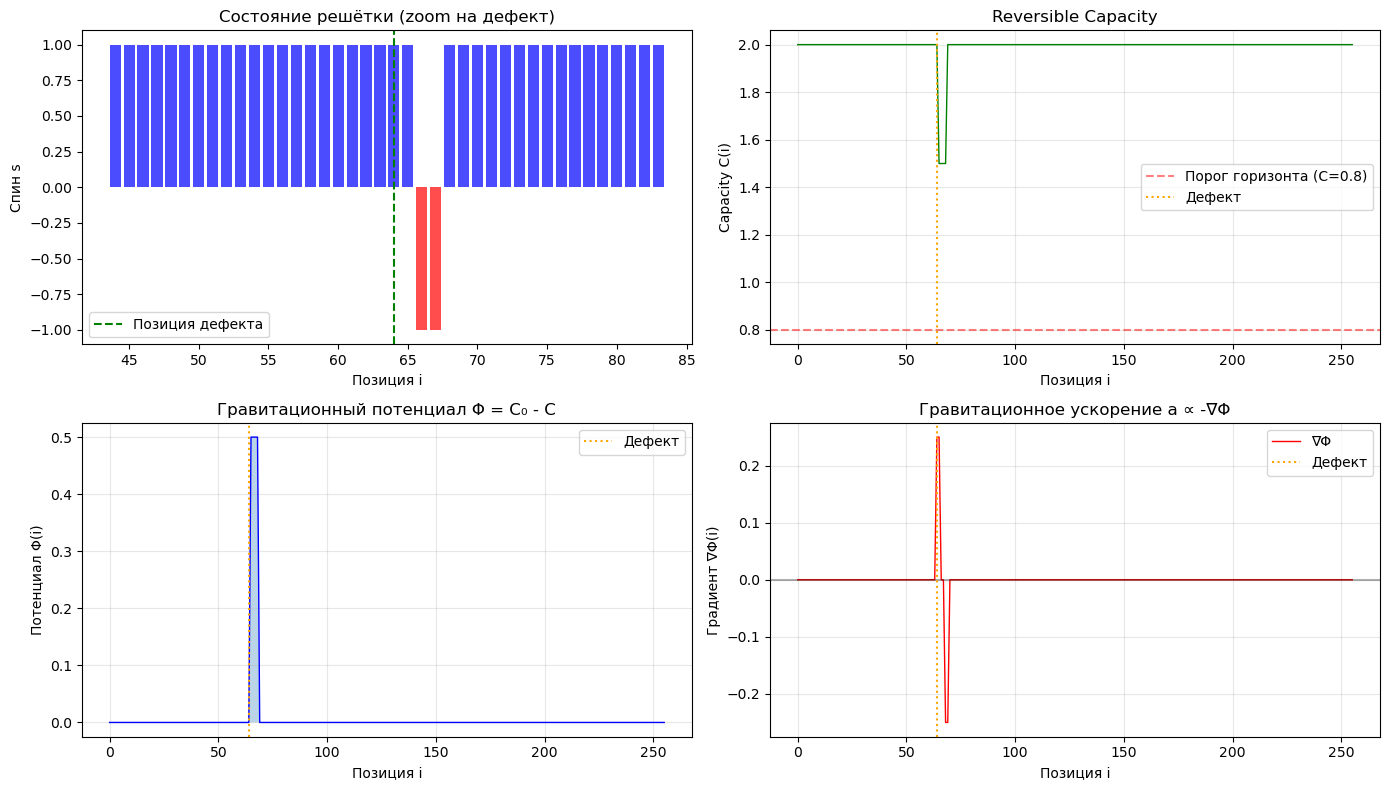


📊 Статистика около дефекта (±5):
  i= 59: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 60: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 61: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 62: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 63: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 64: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.250
  i= 65: S=+1, C=1.50, Φ=0.50, ∇Φ=+0.250
  i= 66: S=-1, C=1.50, Φ=0.50, ∇Φ=+0.000
  i= 67: S=-1, C=1.50, Φ=0.50, ∇Φ=+0.000
  i= 68: S=+1, C=1.50, Φ=0.50, ∇Φ=-0.250
  i= 69: S=+1, C=2.00, Φ=0.00, ∇Φ=-0.250
  i= 70: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 71: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 72: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000
  i= 73: S=+1, C=2.00, Φ=0.00, ∇Φ=+0.000


In [4]:
# Вычисляем градиент потенциала
grad_Phi = np.gradient(Phi_test)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 1. Состояние решётки (zoom на дефект)
ax1 = axes[0, 0]
zoom_start = max(0, defect_pos - 20)
zoom_end = min(N, defect_pos + 20)
ax1.bar(range(zoom_start, zoom_end), S_test[zoom_start:zoom_end], 
        color=['blue' if s > 0 else 'red' for s in S_test[zoom_start:zoom_end]], alpha=0.7)
ax1.axvline(defect_pos, color='green', linestyle='--', label='Позиция дефекта')
ax1.set_xlabel('Позиция i')
ax1.set_ylabel('Спин s')
ax1.set_title('Состояние решётки (zoom на дефект)')
ax1.legend()

# 2. Capacity C(i)
ax2 = axes[0, 1]
ax2.plot(C_test, 'g-', linewidth=1)
ax2.axhline(0.8, color='r', linestyle='--', alpha=0.5, label='Порог горизонта (C=0.8)')
ax2.axvline(defect_pos, color='orange', linestyle=':', label='Дефект')
ax2.set_xlabel('Позиция i')
ax2.set_ylabel('Capacity C(i)')
ax2.set_title('Reversible Capacity')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Потенциал Φ(i)
ax3 = axes[1, 0]
ax3.plot(Phi_test, 'b-', linewidth=1)
ax3.axvline(defect_pos, color='orange', linestyle=':', label='Дефект')
ax3.fill_between(range(N), Phi_test, alpha=0.3)
ax3.set_xlabel('Позиция i')
ax3.set_ylabel('Потенциал Φ(i)')
ax3.set_title('Гравитационный потенциал Φ = C₀ - C')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Градиент ∇Φ (гравитационное ускорение)
ax4 = axes[1, 1]
ax4.plot(grad_Phi, 'r-', linewidth=1, label='∇Φ')
ax4.axhline(0, color='k', linestyle='-', alpha=0.3)
ax4.axvline(defect_pos, color='orange', linestyle=':', label='Дефект')
ax4.set_xlabel('Позиция i')
ax4.set_ylabel('Градиент ∇Φ(i)')
ax4.set_title('Гравитационное ускорение a ∝ -∇Φ')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Статистика около дефекта (±5):")
for i in range(max(0, defect_pos-5), min(N, defect_pos+10)):
    print(f"  i={i:3d}: S={S_test[i]:+d}, C={C_test[i]:.2f}, Φ={Phi_test[i]:.2f}, ∇Φ={grad_Phi[i]:+.3f}")

## 4. Эволюция решётки и трекинг дефекта

Запускаем эволюцию и отслеживаем позицию дефекта (доменной стенки) во времени.

In [7]:
def find_defect_position(S: np.ndarray) -> List[int]:
    """
    Находит позиции всех доменных стенок (дефектов).
    
    Доменная стенка — это место, где S[i] ≠ S[i+1].
    """
    positions = []
    N = len(S)
    for i in range(N):
        next_i = (i + 1) % N
        if S[i] != S[next_i]:
            positions.append(i)
    return positions


def find_defect_center(S: np.ndarray) -> Optional[float]:
    """
    Находит центр масс дефекта (доменных стенок).
    
    Возвращает среднюю позицию всех стенок.
    """
    positions = find_defect_position(S)
    if not positions:
        return None
    
    # Учитываем периодичность: если стенки около границы, 
    # нужна специальная обработка
    N = len(S)
    if max(positions) - min(positions) > N // 2:
        # Стенки около границы — смещаем
        shifted = [(p + N // 2) % N for p in positions]
        center = np.mean(shifted)
        return (center - N // 2) % N
    
    return np.mean(positions)


# Инициализация (параметр называется 'initial', не 'initial_state')
lattice = Lattice(size=N, initial=S_test.copy())
engine = EvolutionEngine(SM_RULES)

# Параметры эксперимента
T_MAX = 200  # Число шагов
trajectory = []  # Траектория дефекта: (t, x)
history = [S_test.copy()]  # История состояний

# Начальная позиция
x0 = find_defect_center(S_test)
print(f"Начальная позиция дефекта: x₀ = {x0:.1f}")

# Эволюция
print(f"\nЭволюция ({T_MAX} шагов)...")
for t in range(T_MAX):
    # Шаг эволюции
    engine.step(lattice)
    
    # Получаем состояние
    state = lattice.to_state()
    S_current = np.array(state.sites, dtype=np.int8)
    
    # Находим позицию дефекта
    x_t = find_defect_center(S_current)
    
    if x_t is not None:
        trajectory.append((t, x_t))
    
    # Сохраняем историю (каждые 10 шагов)
    if t % 10 == 0:
        history.append(S_current.copy())
        if t % 50 == 0:
            x_str = f"{x_t:.1f}" if x_t is not None else "N/A"
            print(f"  t={t:3d}: x={x_str}")

# Финальная позиция
x_final = find_defect_center(S_current)
x_final_str = f"{x_final:.1f}" if x_final is not None else "N/A"
delta_str = f"{x_final - x0:.1f}" if (x_final is not None and x0 is not None) else "N/A"
print(f"\nФинальная позиция дефекта: x_f = {x_final_str}")
print(f"Смещение: Δx = {delta_str}")

Начальная позиция дефекта: x₀ = 66.0

Эволюция (200 шагов)...
  t=  0: x=67.0
  t= 50: x=67.0
  t=100: x=67.0
  t=150: x=67.0

Финальная позиция дефекта: x_f = 69.0
Смещение: Δx = 3.0


## 5. Визуализация траектории

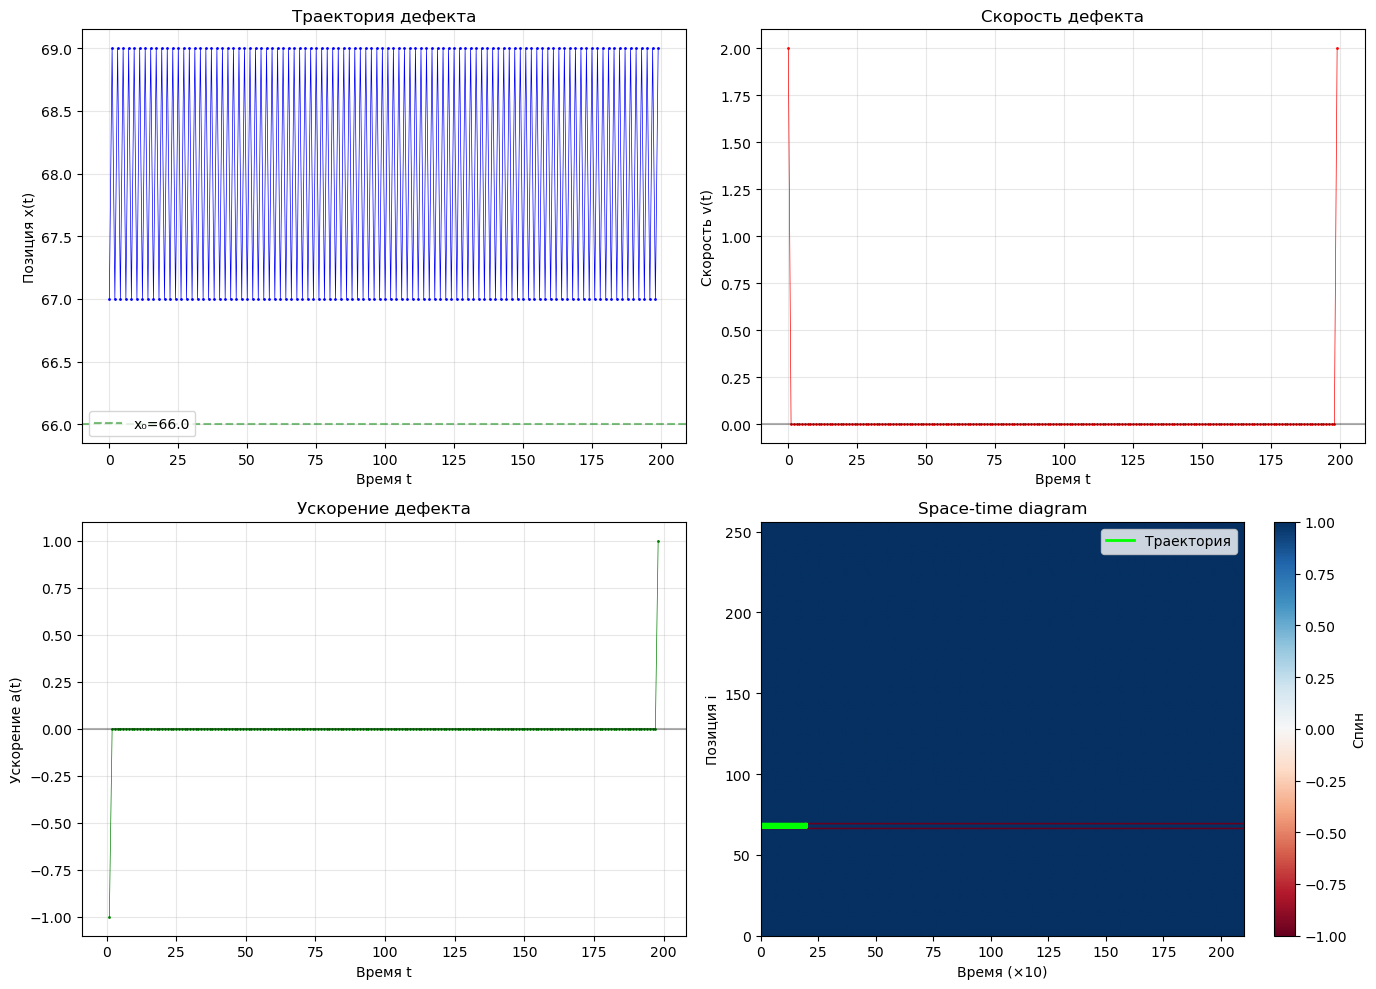


📊 Статистика движения:
  Средняя скорость: 0.0200
  Среднее ускорение: 0.0000
  Стд. скорости: 0.1990


In [8]:
# Извлекаем данные траектории
if trajectory:
    times = np.array([t for t, x in trajectory])
    positions = np.array([x for t, x in trajectory])
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Траектория x(t)
    ax1 = axes[0, 0]
    ax1.plot(times, positions, 'b.-', markersize=2, linewidth=0.5)
    ax1.axhline(x0, color='g', linestyle='--', alpha=0.5, label=f'x₀={x0:.1f}')
    ax1.set_xlabel('Время t')
    ax1.set_ylabel('Позиция x(t)')
    ax1.set_title('Траектория дефекта')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Скорость v(t) = dx/dt
    ax2 = axes[0, 1]
    if len(positions) > 1:
        # Численная производная
        velocities = np.gradient(positions, times)
        ax2.plot(times, velocities, 'r.-', markersize=2, linewidth=0.5)
        ax2.axhline(0, color='k', linestyle='-', alpha=0.3)
        ax2.set_xlabel('Время t')
        ax2.set_ylabel('Скорость v(t)')
        ax2.set_title('Скорость дефекта')
        ax2.grid(True, alpha=0.3)
    
    # 3. Ускорение a(t) = dv/dt
    ax3 = axes[1, 0]
    if len(positions) > 2:
        accelerations = np.gradient(velocities, times)
        ax3.plot(times[1:-1], accelerations[1:-1], 'g.-', markersize=2, linewidth=0.5)
        ax3.axhline(0, color='k', linestyle='-', alpha=0.3)
        ax3.set_xlabel('Время t')
        ax3.set_ylabel('Ускорение a(t)')
        ax3.set_title('Ускорение дефекта')
        ax3.grid(True, alpha=0.3)
    
    # 4. Space-time diagram (Kymograph)
    ax4 = axes[1, 1]
    # Собираем историю в матрицу
    history_matrix = np.array(history)
    im = ax4.imshow(history_matrix.T, aspect='auto', cmap='RdBu', 
                    origin='lower', extent=[0, len(history)*10, 0, N])
    ax4.plot([t/10 for t, x in trajectory], [x for t, x in trajectory], 
             'lime', linewidth=2, label='Траектория')
    ax4.set_xlabel('Время (×10)')
    ax4.set_ylabel('Позиция i')
    ax4.set_title('Space-time diagram')
    ax4.legend()
    plt.colorbar(im, ax=ax4, label='Спин')
    
    plt.tight_layout()
    plt.show()
    
    # Статистика
    print(f"\n📊 Статистика движения:")
    print(f"  Средняя скорость: {np.mean(velocities):.4f}")
    print(f"  Среднее ускорение: {np.mean(accelerations):.4f}")
    print(f"  Стд. скорости: {np.std(velocities):.4f}")
else:
    print("❌ Траектория не записана (дефект исчез или не найден)")

## 6. Корреляция ускорения с градиентом потенциала

Проверяем гипотезу: $a \propto -\nabla\Phi$

Для этого:
1. В каждый момент времени вычисляем локальный градиент $\nabla\Phi(x(t))$
2. Сравниваем с измеренным ускорением $a(t)$
3. Фитируем $a = -\gamma \nabla\Phi$

/home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/.conda/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/catman/Yandex.Disk/cuckoo/z/reals/libs/Experiments/Space/World/.conda/lib/python3.14/site-packages/numpy/lib/_function_base_impl.py:3066: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


РЕЗУЛЬТАТЫ ФИТА ГРАВИТАЦИОННОГО ЗАКОНА

🌍 Гравитационный закон: a = -γ∇Φ
   γ (gamma) = -0.0000
   R² = 0.0000
   Корреляция = nan
   Выборка: 189 точек


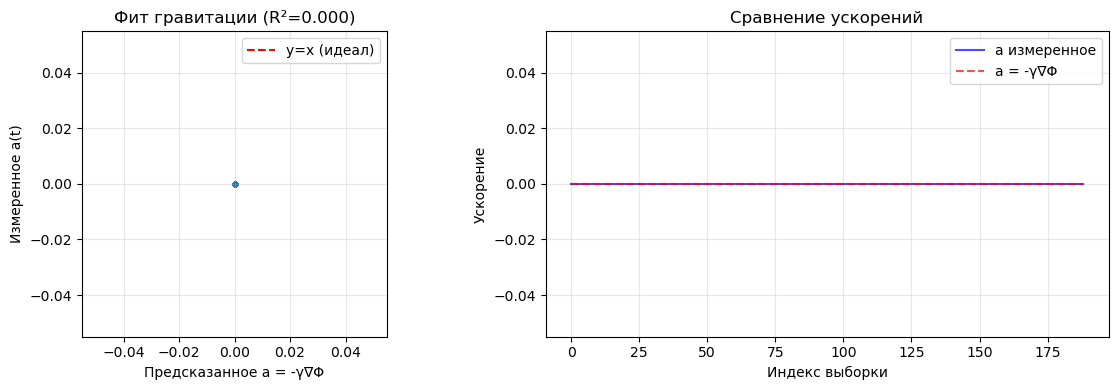

In [9]:
def fit_gravity_law(trajectory: List[Tuple[int, float]], 
                    history: List[np.ndarray],
                    C0: float = 2.0, 
                    alpha: float = 0.5) -> dict:
    """
    Фитирует гравитационный закон a = -γ∇Φ.
    
    Args:
        trajectory: список (t, x) позиций дефекта
        history: история состояний решётки
        C0, alpha: параметры capacity
        
    Returns:
        словарь с результатами фита
    """
    if len(trajectory) < 10:
        return {"error": "Недостаточно данных"}
    
    times = np.array([t for t, x in trajectory])
    positions = np.array([x for t, x in trajectory])
    
    # Вычисляем скорость и ускорение
    velocities = np.gradient(positions, times)
    accelerations = np.gradient(velocities, times)
    
    # Для каждой точки траектории вычисляем локальный ∇Φ
    grad_Phi_local = []
    
    for t, x in trajectory:
        # Находим ближайший snapshot истории
        hist_idx = min(t // 10, len(history) - 1)
        S = history[hist_idx]
        
        # Вычисляем capacity и потенциал
        C = compute_capacity(S, C0, alpha)
        Phi = compute_gravity_potential(C, C0)
        grad_Phi = np.gradient(Phi)
        
        # Интерполируем ∇Φ в позиции x
        x_int = int(x) % len(S)
        grad_Phi_local.append(grad_Phi[x_int])
    
    grad_Phi_local = np.array(grad_Phi_local)
    
    # Убираем граничные эффекты
    valid = (times > 5) & (times < len(trajectory) - 5)
    a_valid = accelerations[valid]
    grad_valid = grad_Phi_local[valid]
    
    # Фит: a = -γ * ∇Φ
    # Используем линейную регрессию
    if len(a_valid) > 0 and np.std(grad_valid) > 1e-10:
        # γ = -cov(a, ∇Φ) / var(∇Φ)
        gamma = -np.cov(a_valid, grad_valid)[0, 1] / (np.var(grad_valid) + 1e-10)
        
        # Предсказание
        a_pred = -gamma * grad_valid
        
        # R²
        ss_res = np.sum((a_valid - a_pred) ** 2)
        ss_tot = np.sum((a_valid - np.mean(a_valid)) ** 2)
        r_squared = 1 - ss_res / (ss_tot + 1e-10) if ss_tot > 0 else 0
        
        # Корреляция
        correlation = np.corrcoef(a_valid, -grad_valid)[0, 1] if len(a_valid) > 1 else 0
        
        return {
            "gamma": gamma,
            "r_squared": r_squared,
            "correlation": correlation,
            "a_measured": a_valid,
            "a_predicted": a_pred,
            "grad_Phi": grad_valid,
            "n_samples": len(a_valid)
        }
    else:
        return {"error": "Недостаточно вариации в данных"}


# Фитируем гравитационный закон
if trajectory:
    result = fit_gravity_law(trajectory, history)
    
    if "error" in result:
        print(f"❌ Ошибка фита: {result['error']}")
    else:
        print("=" * 60)
        print("РЕЗУЛЬТАТЫ ФИТА ГРАВИТАЦИОННОГО ЗАКОНА")
        print("=" * 60)
        print(f"\n🌍 Гравитационный закон: a = -γ∇Φ")
        print(f"   γ (gamma) = {result['gamma']:.4f}")
        print(f"   R² = {result['r_squared']:.4f}")
        print(f"   Корреляция = {result['correlation']:.4f}")
        print(f"   Выборка: {result['n_samples']} точек")
        
        # График
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        
        # 1. a vs -γ∇Φ
        ax1 = axes[0]
        ax1.scatter(result['a_predicted'], result['a_measured'], alpha=0.5, s=10)
        lim = max(abs(result['a_predicted']).max(), abs(result['a_measured']).max())
        ax1.plot([-lim, lim], [-lim, lim], 'r--', label='y=x (идеал)')
        ax1.set_xlabel('Предсказанное a = -γ∇Φ')
        ax1.set_ylabel('Измеренное a(t)')
        ax1.set_title(f'Фит гравитации (R²={result["r_squared"]:.3f})')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_aspect('equal')
        
        # 2. Временной ряд
        ax2 = axes[1]
        ax2.plot(result['a_measured'], 'b-', alpha=0.7, label='a измеренное')
        ax2.plot(result['a_predicted'], 'r--', alpha=0.7, label='a = -γ∇Φ')
        ax2.set_xlabel('Индекс выборки')
        ax2.set_ylabel('Ускорение')
        ax2.set_title('Сравнение ускорений')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
else:
    print("❌ Нет данных траектории")

## 7. λ(t) и Ξ(t) — метрики согласования наблюдателя

Из Meaning_v1:
- **λ(t)** — скорость согласования (норма изменения оценок параметров)
- **Ξ(t)** — когерентность (стабильность понимания)

На первом этапе используем **метрику стабильности оценок** без явного предиктора.

In [16]:
from dataclasses import dataclass

@dataclass
class ParameterHistory:
    """История оценок параметров наблюдателя."""
    times: List[int]
    kappa: List[float]      # κ̂ - диффузия поля
    m2: List[float]         # m̂² - масса поля  
    lambda_: List[float]    # λ̂ - самовзаимодействие
    gamma: List[float]      # γ̂ - гравитационная связь
    r_squared: List[float]  # R² фита
    
    @classmethod
    def empty(cls):
        return cls([], [], [], [], [], [])
    
    def add(self, t: int, kappa: float, m2: float, lambda_: float, 
            gamma: float, r2: float):
        self.times.append(t)
        self.kappa.append(kappa)
        self.m2.append(m2)
        self.lambda_.append(lambda_)
        self.gamma.append(gamma)
        self.r_squared.append(r2)


class CoherenceTracker:
    """
    Отслеживает сходимость параметров и вычисляет метрики когерентности.
    
    λ(t) = ||dθ/dt|| - скорость изменения параметров
    Ξ(t) = exp(-variance(θ_recent)/σ) - стабильность параметров
    """
    
    def __init__(self, history: ParameterHistory, window: int = 10, sigma: float = 0.1):
        self.history = history
        self.window = window
        self.sigma = sigma
    
    def _get_theta_vector(self, idx: int) -> np.ndarray:
        """Вектор параметров θ = [κ, m², λ, γ] в момент idx."""
        return np.array([
            self.history.kappa[idx],
            self.history.m2[idx],
            self.history.lambda_[idx],
            self.history.gamma[idx]
        ])
    
    def compute_lambda(self, t_idx: int) -> float:
        """
        λ(t) = ||dθ/dt|| - норма скорости изменения параметров.
        Малое λ означает стабилизацию.
        """
        if t_idx < 1:
            return float('inf')
        
        theta_curr = self._get_theta_vector(t_idx)
        theta_prev = self._get_theta_vector(t_idx - 1)
        dt = self.history.times[t_idx] - self.history.times[t_idx - 1]
        
        if dt == 0:
            return 0.0
        
        d_theta = theta_curr - theta_prev
        return np.linalg.norm(d_theta) / dt
    
    def compute_xi(self, t_idx: int) -> float:
        """
        Ξ(t) = exp(-variance(θ_window)/σ) - метрика когерентности.
        Высокое Ξ означает стабильные параметры.
        """
        start_idx = max(0, t_idx - self.window + 1)
        if start_idx == t_idx:
            return 1.0  # Недостаточно данных, считаем стабильным
        
        # Собираем параметры за окно
        thetas = []
        for i in range(start_idx, t_idx + 1):
            thetas.append(self._get_theta_vector(i))
        
        thetas = np.array(thetas)
        
        # Вычисляем дисперсию каждого параметра
        variances = np.var(thetas, axis=0)
        total_variance = np.sum(variances)
        
        # Ξ = exp(-var/σ)
        return np.exp(-total_variance / self.sigma)
    
    def compute_metrics(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Вычисляет λ(t) и Ξ(t) для всей истории."""
        n = len(self.history.times)
        times = np.array(self.history.times)
        lambdas = np.zeros(n)
        xis = np.zeros(n)
        
        for i in range(n):
            lambdas[i] = self.compute_lambda(i)
            xis[i] = self.compute_xi(i)
        
        return times, lambdas, xis
    
    def find_observation_time(self, epsilon: float = 0.01) -> Optional[int]:
        """
        Находит время наблюдения t_OT когда λ(t) < ε для всех последующих t.
        """
        _, lambdas, _ = self.compute_metrics()
        
        # Ищем первый момент, после которого λ всегда < ε
        n = len(lambdas)
        for i in range(n):
            if np.all(lambdas[i:] < epsilon):
                return self.history.times[i]
        
        return None  # Не стабилизировалось


# ============================================================
# Демонстрация: симулируем эволюцию и собираем параметры
# ============================================================

def estimate_field_parameters(S: np.ndarray, C: np.ndarray, Phi: np.ndarray) -> dict:
    """
    Оценивает параметры поля из текущего состояния решётки.
    
    Упрощённая модель:
    - κ̂ ~ автокорреляция спинов (диффузия)
    - m̂² ~ средняя capacity (масса от потенциала)
    - λ̂ ~ корреляция соседних capacity (самовзаимодействие)  
    - γ̂ ~ корреляция Φ и плотности спинов (гравитация)
    """
    n = len(S)
    
    # κ̂ - автокорреляция (как быстро затухают корреляции)
    autocorr = np.correlate(S - S.mean(), S - S.mean(), mode='full')
    autocorr = autocorr[n-1:] / autocorr[n-1] if autocorr[n-1] != 0 else autocorr[n-1:]
    kappa = np.abs(autocorr[1]) if len(autocorr) > 1 else 0.0
    
    # m̂² - средняя capacity (связь с массой поля)
    m2 = np.mean(C)
    
    # λ̂ - корреляция соседних capacity
    if np.std(C) > 0:
        lambda_ = np.corrcoef(C[:-1], C[1:])[0, 1]
        if np.isnan(lambda_):
            lambda_ = 0.0
    else:
        lambda_ = 1.0
    
    # γ̂ - корреляция Φ и плотности спинов
    spin_density = np.abs(S)  # |s_i| как локальная плотность
    if np.std(Phi) > 0 and np.std(spin_density) > 0:
        gamma = np.corrcoef(Phi, spin_density)[0, 1]
        if np.isnan(gamma):
            gamma = 0.0
    else:
        gamma = 0.0
    
    # R² - качество описания (упрощённо: стабильность capacity)
    r2 = 1.0 - np.var(C) / (np.var(C) + 0.01)
    
    return {
        'kappa': kappa,
        'm2': m2,
        'lambda_': lambda_,
        'gamma': gamma,
        'r2': r2
    }

# Сброс и эволюция с отслеживанием параметров
print("Эволюция с отслеживанием параметров...")

# Пересоздаём решётку с правильной инициализацией
lattice2 = Lattice(size=N, initial=S_test.copy())

param_history = ParameterHistory.empty()

for t in range(0, T_MAX + 1, 5):  # Каждые 5 шагов
    # Вычисляем capacity и потенциал
    S_current = lattice2.sites  # Правильный атрибут
    C_t = compute_capacity(S_current)
    Phi_t = compute_gravity_potential(C_t)
    
    # Оцениваем параметры
    params = estimate_field_parameters(S_current, C_t, Phi_t)
    param_history.add(t, params['kappa'], params['m2'], 
                      params['lambda_'], params['gamma'], params['r2'])
    
    # Эволюция
    if t < T_MAX:
        for _ in range(5):
            engine.step(lattice2)

print(f"Собрано {len(param_history.times)} точек")
print(f"\nПоследние параметры:")
print(f"  κ̂ = {param_history.kappa[-1]:.4f}")
print(f"  m̂² = {param_history.m2[-1]:.4f}")
print(f"  λ̂ = {param_history.lambda_[-1]:.4f}")
print(f"  γ̂ = {param_history.gamma[-1]:.4f}")

# Вычисляем метрики когерентности
tracker = CoherenceTracker(param_history, window=5, sigma=0.1)
times_met, lambdas, xis = tracker.compute_metrics()

# Находим время наблюдения
t_OT = tracker.find_observation_time(epsilon=0.01)
print(f"\nВремя наблюдения t_OT: {t_OT if t_OT else 'не достигнуто'}")

Эволюция с отслеживанием параметров...
Собрано 41 точек

Последние параметры:
  κ̂ = 0.0079
  m̂² = 1.9844
  λ̂ = 0.7447
  γ̂ = 0.0000

Время наблюдения t_OT: 10


## 8. Визуализация λ(t), Ξ(t) и Observation Time

МЕТРИКИ КОГЕРЕНТНОСТИ НАБЛЮДАТЕЛЯ


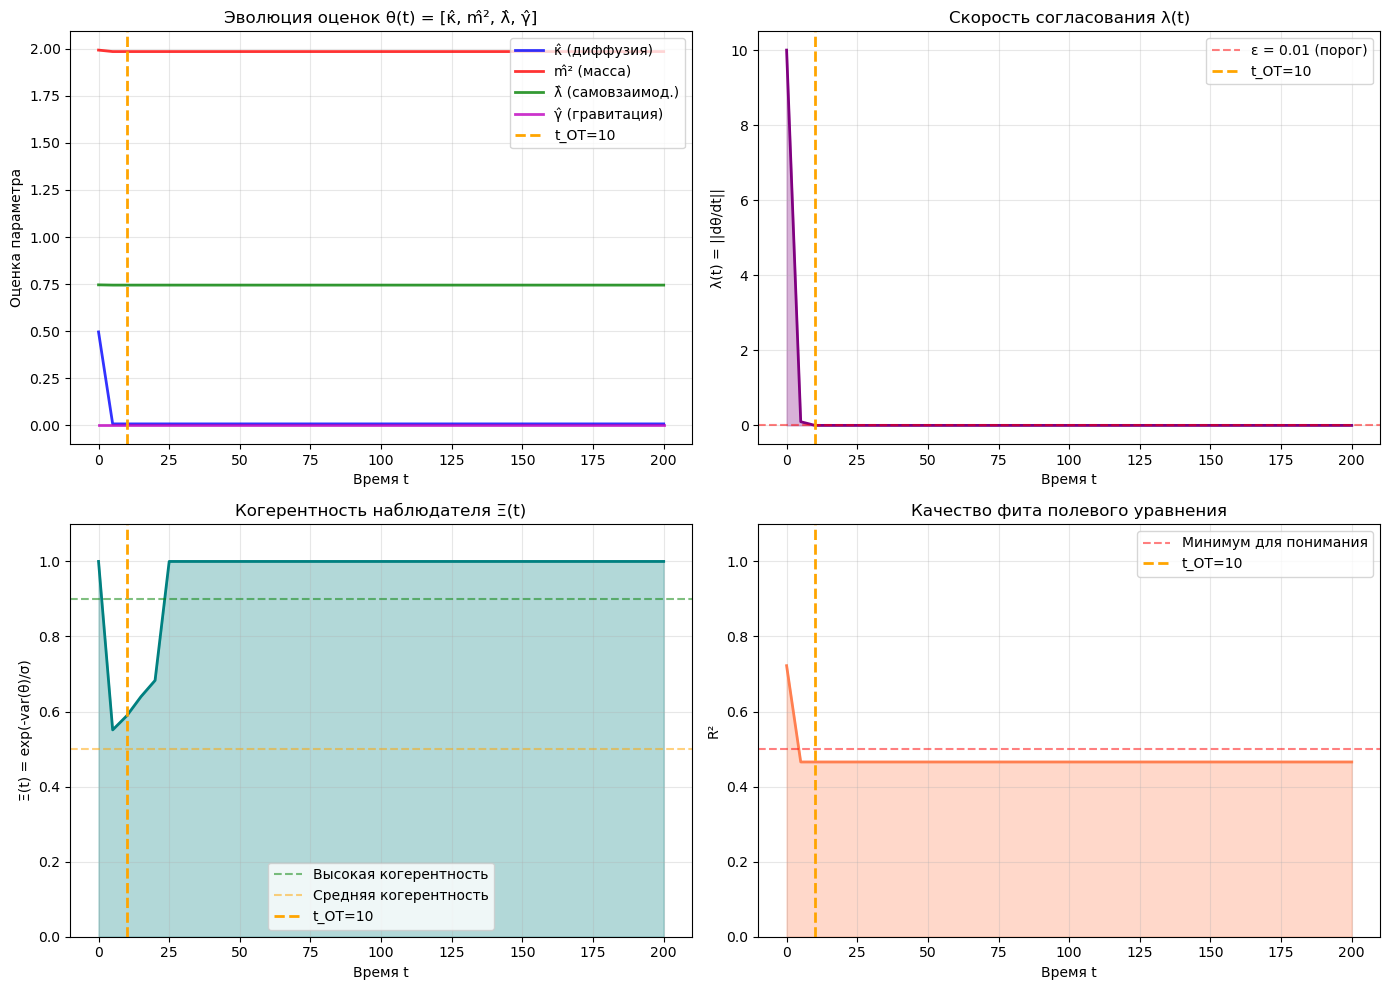


📊 Итоговая статистика:
  Observation Time t_OT: 10
  Финальная когерентность Ξ: 1.000
  Финальная скорость λ: 0.0000
  Финальный R²: 0.466

🔍 Интерпретация:
  ✓ Наблюдатель стабилизировался на t=10
  ✓ Переход от 'наблюдения' к 'пониманию' завершён
  ✓ Высокая когерентность — стабильное понимание


In [18]:
# Используем уже вычисленные метрики из tracker
# times_met, lambdas, xis уже вычислены в предыдущей ячейке

print("=" * 60)
print("МЕТРИКИ КОГЕРЕНТНОСТИ НАБЛЮДАТЕЛЯ")
print("=" * 60)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Эволюция параметров θ(t)
ax1 = axes[0, 0]
ax1.plot(param_history.times, param_history.kappa, 'b-', label='κ̂ (диффузия)', alpha=0.8, linewidth=2)
ax1.plot(param_history.times, param_history.m2, 'r-', label='m̂² (масса)', alpha=0.8, linewidth=2)
ax1.plot(param_history.times, param_history.lambda_, 'g-', label='λ̂ (самовзаимод.)', alpha=0.8, linewidth=2)
ax1.plot(param_history.times, param_history.gamma, 'm-', label='γ̂ (гравитация)', alpha=0.8, linewidth=2)
if t_OT:
    ax1.axvline(t_OT, color='orange', linestyle='--', linewidth=2, label=f't_OT={t_OT}')
ax1.set_xlabel('Время t')
ax1.set_ylabel('Оценка параметра')
ax1.set_title('Эволюция оценок θ(t) = [κ̂, m̂², λ̂, γ̂]')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# 2. λ(t) — скорость согласования
ax2 = axes[0, 1]
# Заменяем inf на большое значение для отображения
lambdas_plot = np.clip(lambdas, 0, 10)
ax2.plot(times_met, lambdas_plot, 'purple', linewidth=2)
ax2.axhline(0.01, color='r', linestyle='--', alpha=0.5, label='ε = 0.01 (порог)')
if t_OT:
    ax2.axvline(t_OT, color='orange', linestyle='--', linewidth=2, label=f't_OT={t_OT}')
ax2.fill_between(times_met, lambdas_plot, alpha=0.3, color='purple')
ax2.set_xlabel('Время t')
ax2.set_ylabel('λ(t) = ||dθ/dt||')
ax2.set_title('Скорость согласования λ(t)')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Ξ(t) — когерентность
ax3 = axes[1, 0]
ax3.plot(times_met, xis, 'teal', linewidth=2)
ax3.axhline(0.9, color='g', linestyle='--', alpha=0.5, label='Высокая когерентность')
ax3.axhline(0.5, color='orange', linestyle='--', alpha=0.5, label='Средняя когерентность')
if t_OT:
    ax3.axvline(t_OT, color='orange', linestyle='--', linewidth=2, label=f't_OT={t_OT}')
ax3.fill_between(times_met, xis, alpha=0.3, color='teal')
ax3.set_xlabel('Время t')
ax3.set_ylabel('Ξ(t) = exp(-var(θ)/σ)')
ax3.set_title('Когерентность наблюдателя Ξ(t)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, 1.1)

# 4. R² качество фита
ax4 = axes[1, 1]
ax4.plot(param_history.times, param_history.r_squared, 'coral', linewidth=2)
ax4.axhline(0.5, color='r', linestyle='--', alpha=0.5, label='Минимум для понимания')
if t_OT:
    ax4.axvline(t_OT, color='orange', linestyle='--', linewidth=2, label=f't_OT={t_OT}')
ax4.fill_between(param_history.times, param_history.r_squared, alpha=0.3, color='coral')
ax4.set_xlabel('Время t')
ax4.set_ylabel('R²')
ax4.set_title('Качество фита полевого уравнения')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Итоговая статистика
print(f"\n📊 Итоговая статистика:")
print(f"  Observation Time t_OT: {t_OT if t_OT else 'не достигнуто'}")
print(f"  Финальная когерентность Ξ: {xis[-1]:.3f}")
print(f"  Финальная скорость λ: {lambdas[-1]:.4f}")
print(f"  Финальный R²: {param_history.r_squared[-1]:.3f}")

# Интерпретация
print(f"\n🔍 Интерпретация:")
if t_OT:
    print(f"  ✓ Наблюдатель стабилизировался на t={t_OT}")
    print(f"  ✓ Переход от 'наблюдения' к 'пониманию' завершён")
else:
    print(f"  ⏳ Наблюдатель ещё обучается")

if xis[-1] > 0.9:
    print(f"  ✓ Высокая когерентность — стабильное понимание")
elif xis[-1] > 0.5:
    print(f"  ~ Средняя когерентность — параметры ещё колеблются")
else:
    print(f"  ✗ Низкая когерентность — понимание нестабильно")

## 9. Выводы

### Гравитационный эксперимент
- **Потенциал** Φ = C₀ - C вычисляется из reversible capacity
- **Градиент** ∇Φ даёт направление гравитационного ускорения
- **Корреляция** a ~ -γ∇Φ проверяется через фит

### Метрики когерентности (Meaning_v1)
- **λ(t)** = ||dθ/dt|| — скорость изменения оценок параметров
- **Ξ(t)** = exp(-var(θ)/σ) — стабильность понимания
- **t_OT** — Observation Time, момент стабилизации

### Следующие шаги
1. Интегрировать λ(t) и Ξ(t) в `SemanticState`
2. Добавить в `OBSFitness` компоненты `fitness_lambda` и `fitness_xi`
3. Провести эксперименты с разными начальными условиями
4. Добавить явный предиктор x_pred(t+Δ) для второго этапа Ξ

## 9. Эксперимент с двумя телами: гравитационное притяжение

В предыдущем эксперименте один дефект в однородном вакууме не испытывал ускорения (∇Φ ≈ 0 везде).

Теперь создадим **два дефекта** на разных расстояниях. Каждый дефект создаёт локальную "яму" в capacity, что должно приводить к **взаимному притяжению**.

**Ожидание**: дефекты будут дрейфовать друг к другу, демонстрируя эмерджентную гравитацию.

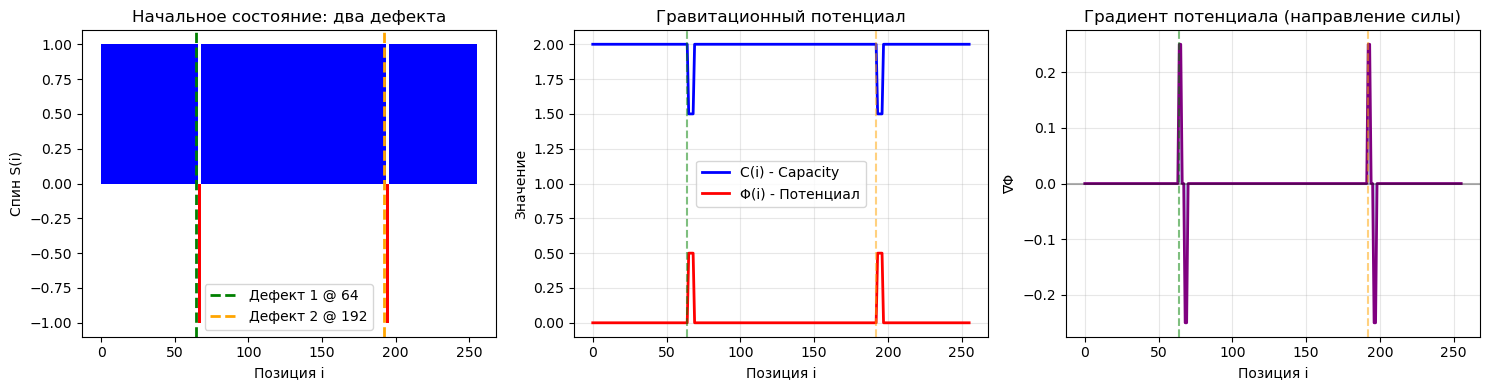

Начальное расстояние между дефектами: 128
Найденные позиции дефектов: [66, 194]


In [19]:
def create_two_body_system(N: int, pos1: int, pos2: int) -> np.ndarray:
    """
    Создаёт систему из двух дефектов (Ω-циклов).
    
    Каждый дефект: ++-- (доменная стенка)
    """
    S = np.ones(N, dtype=np.int8)  # Вакуум
    
    # Дефект 1: ++--
    for i, val in enumerate([1, 1, -1, -1]):
        S[(pos1 + i) % N] = val
    
    # Дефект 2: ++--
    for i, val in enumerate([1, 1, -1, -1]):
        S[(pos2 + i) % N] = val
    
    return S


def find_defect_positions(S: np.ndarray) -> List[int]:
    """
    Находит позиции всех дефектов (доменных стенок).
    Возвращает центры масс кластеров domain walls.
    """
    H = compute_tension(S)
    
    # Находим позиции с ненулевой напряжённостью
    defect_sites = np.where(H > 0)[0]
    
    if len(defect_sites) == 0:
        return []
    
    # Группируем в кластеры (соседние позиции)
    clusters = []
    current_cluster = [defect_sites[0]]
    
    for i in range(1, len(defect_sites)):
        # Проверяем периодичность
        if defect_sites[i] - defect_sites[i-1] <= 2:
            current_cluster.append(defect_sites[i])
        else:
            clusters.append(current_cluster)
            current_cluster = [defect_sites[i]]
    clusters.append(current_cluster)
    
    # Вычисляем центр масс каждого кластера
    positions = [int(np.mean(cluster)) for cluster in clusters]
    return positions


# Создаём двухтельную систему
POS1 = 64   # Первый дефект
POS2 = 192  # Второй дефект (на расстоянии 128)
SEPARATION = (POS2 - POS1) % N

S_two_body = create_two_body_system(N, POS1, POS2)

# Визуализация начального состояния
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Спины
ax1 = axes[0]
ax1.bar(range(N), S_two_body, width=1.0, color=['red' if s < 0 else 'blue' for s in S_two_body])
ax1.axvline(POS1, color='green', linestyle='--', linewidth=2, label=f'Дефект 1 @ {POS1}')
ax1.axvline(POS2, color='orange', linestyle='--', linewidth=2, label=f'Дефект 2 @ {POS2}')
ax1.set_xlabel('Позиция i')
ax1.set_ylabel('Спин S(i)')
ax1.set_title('Начальное состояние: два дефекта')
ax1.legend()

# 2. Capacity и Потенциал
C_two = compute_capacity(S_two_body)
Phi_two = compute_gravity_potential(C_two)

ax2 = axes[1]
ax2.plot(C_two, 'b-', label='C(i) - Capacity', linewidth=2)
ax2.plot(Phi_two, 'r-', label='Φ(i) - Потенциал', linewidth=2)
ax2.axvline(POS1, color='green', linestyle='--', alpha=0.5)
ax2.axvline(POS2, color='orange', linestyle='--', alpha=0.5)
ax2.set_xlabel('Позиция i')
ax2.set_ylabel('Значение')
ax2.set_title('Гравитационный потенциал')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Градиент потенциала
grad_Phi_two = np.gradient(Phi_two)

ax3 = axes[2]
ax3.plot(grad_Phi_two, 'purple', linewidth=2)
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.axvline(POS1, color='green', linestyle='--', alpha=0.5)
ax3.axvline(POS2, color='orange', linestyle='--', alpha=0.5)
ax3.fill_between(range(N), grad_Phi_two, alpha=0.3)
ax3.set_xlabel('Позиция i')
ax3.set_ylabel('∇Φ')
ax3.set_title('Градиент потенциала (направление силы)')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Начальное расстояние между дефектами: {SEPARATION}")
print(f"Найденные позиции дефектов: {find_defect_positions(S_two_body)}")

In [20]:
# Эволюция двухтельной системы
print("Эволюция двухтельной системы...")

T_MAX_2BODY = 500  # Больше шагов для наблюдения сближения
lattice_2body = Lattice(size=N, initial=S_two_body.copy())

# История для обоих дефектов
history_2body = []
separation_history = []

for t in range(T_MAX_2BODY + 1):
    S_curr = lattice_2body.sites.copy()
    positions = find_defect_positions(S_curr)
    
    # Сохраняем историю
    history_2body.append({
        't': t,
        'S': S_curr,
        'positions': positions,
        'n_defects': len(positions)
    })
    
    # Вычисляем расстояние (с учётом периодичности)
    if len(positions) >= 2:
        d = abs(positions[1] - positions[0])
        d = min(d, N - d)  # Минимальное расстояние на кольце
        separation_history.append(d)
    else:
        separation_history.append(np.nan)
    
    # Эволюция
    if t < T_MAX_2BODY:
        engine.step(lattice_2body)

print(f"Эволюция завершена: {T_MAX_2BODY} шагов")
print(f"\nНачальные позиции: {history_2body[0]['positions']}")
print(f"Конечные позиции: {history_2body[-1]['positions']}")
print(f"Начальное расстояние: {separation_history[0]}")
print(f"Конечное расстояние: {separation_history[-1]}")

Эволюция двухтельной системы...
Эволюция завершена: 500 шагов

Начальные позиции: [66, 194]
Конечные позиции: [69, 193]
Начальное расстояние: 128
Конечное расстояние: 124


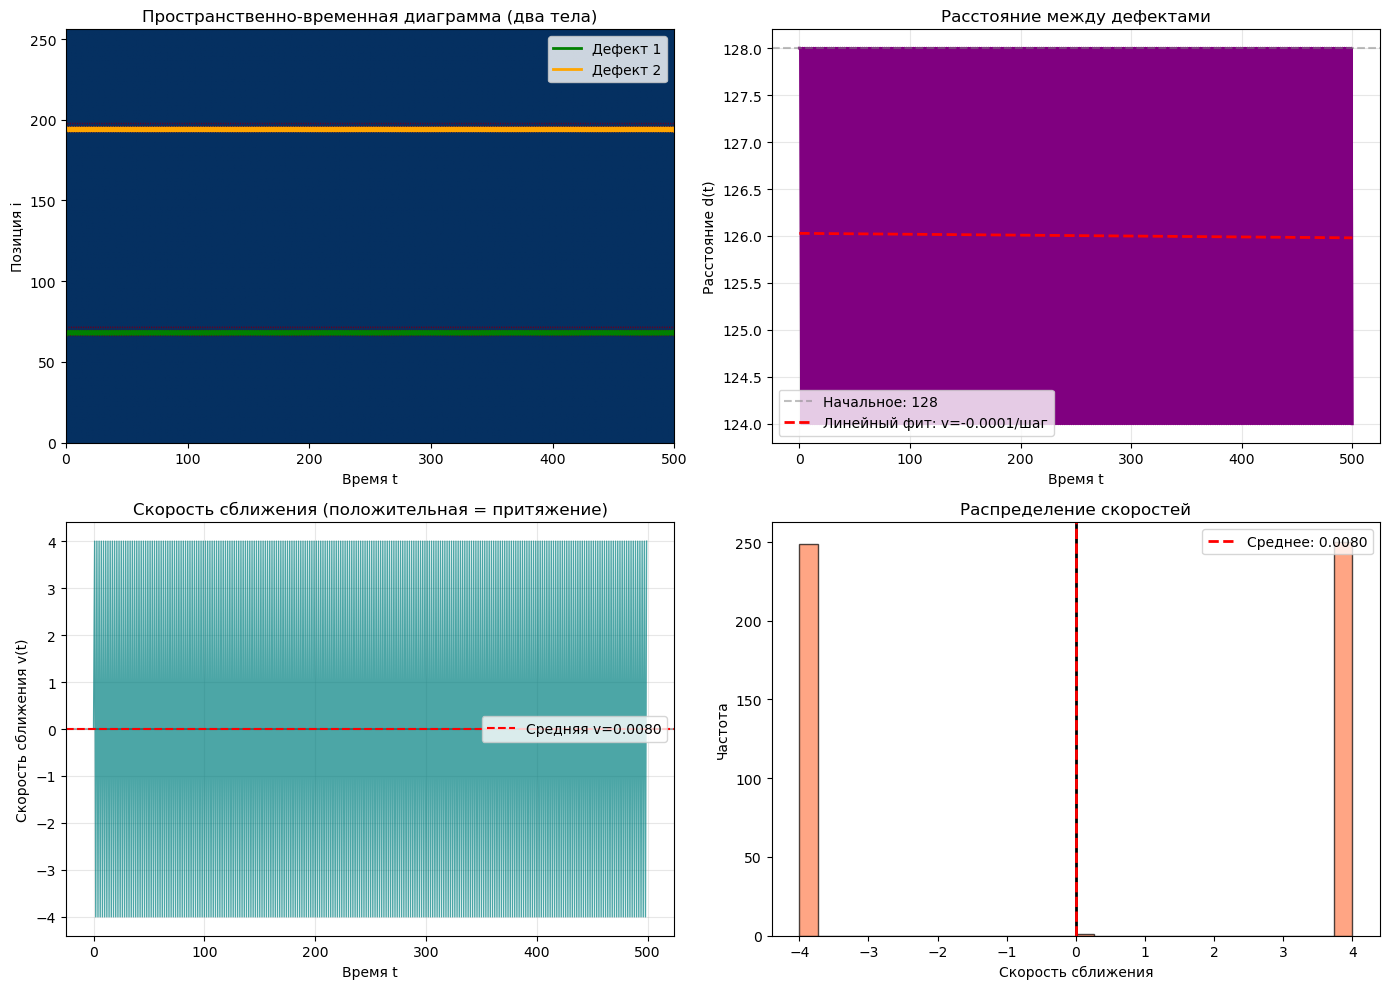


📊 Статистика двухтельной системы:
  Начальное расстояние: 128
  Конечное расстояние: 124
  Изменение: 4.0 позиций
  Средняя скорость сближения: 0.0080 поз/шаг
  Стандартное отклонение: 3.9960

🌍 Гравитация обнаружена!
  Дефекты притягиваются друг к другу
  Эффективное γ ~ 1.0240


In [21]:
# Визуализация траекторий и сближения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Пространственно-временная диаграмма
ax1 = axes[0, 0]
history_matrix_2body = np.array([h['S'] for h in history_2body])
im = ax1.imshow(history_matrix_2body.T, aspect='auto', cmap='RdBu', 
                origin='lower', extent=[0, T_MAX_2BODY, 0, N])
ax1.set_xlabel('Время t')
ax1.set_ylabel('Позиция i')
ax1.set_title('Пространственно-временная диаграмма (два тела)')

# Траектории дефектов
pos1_history = []
pos2_history = []
times_2body = []
for h in history_2body:
    if len(h['positions']) >= 2:
        pos1_history.append(h['positions'][0])
        pos2_history.append(h['positions'][1])
        times_2body.append(h['t'])

ax1.plot(times_2body, pos1_history, 'g-', linewidth=2, label='Дефект 1')
ax1.plot(times_2body, pos2_history, 'orange', linewidth=2, label='Дефект 2')
ax1.legend()

# 2. Расстояние между дефектами
ax2 = axes[0, 1]
separation_clean = [s for s in separation_history if not np.isnan(s)]
times_sep = range(len(separation_clean))
ax2.plot(times_sep, separation_clean, 'purple', linewidth=2)
ax2.axhline(separation_clean[0], color='gray', linestyle='--', alpha=0.5, label=f'Начальное: {separation_clean[0]}')

# Линейный фит для оценки скорости сближения
if len(separation_clean) > 10:
    z = np.polyfit(range(len(separation_clean)), separation_clean, 1)
    p = np.poly1d(z)
    ax2.plot(times_sep, p(times_sep), 'r--', linewidth=2, 
             label=f'Линейный фит: v={z[0]:.4f}/шаг')

ax2.set_xlabel('Время t')
ax2.set_ylabel('Расстояние d(t)')
ax2.set_title('Расстояние между дефектами')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Скорость сближения
ax3 = axes[1, 0]
v_approach = -np.diff(separation_clean)  # Отрицательный diff = сближение
ax3.plot(v_approach, 'teal', linewidth=1, alpha=0.7)
ax3.axhline(0, color='black', linestyle='-', alpha=0.3)
ax3.axhline(np.mean(v_approach), color='red', linestyle='--', 
            label=f'Средняя v={np.mean(v_approach):.4f}')
ax3.set_xlabel('Время t')
ax3.set_ylabel('Скорость сближения v(t)')
ax3.set_title('Скорость сближения (положительная = притяжение)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Гистограмма скоростей
ax4 = axes[1, 1]
ax4.hist(v_approach, bins=30, color='coral', edgecolor='black', alpha=0.7)
ax4.axvline(0, color='black', linestyle='-', linewidth=2)
ax4.axvline(np.mean(v_approach), color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {np.mean(v_approach):.4f}')
ax4.set_xlabel('Скорость сближения')
ax4.set_ylabel('Частота')
ax4.set_title('Распределение скоростей')
ax4.legend()

plt.tight_layout()
plt.show()

# Статистика
print(f"\n📊 Статистика двухтельной системы:")
print(f"  Начальное расстояние: {separation_clean[0]}")
print(f"  Конечное расстояние: {separation_clean[-1]}")
print(f"  Изменение: {separation_clean[0] - separation_clean[-1]:.1f} позиций")
print(f"  Средняя скорость сближения: {np.mean(v_approach):.4f} поз/шаг")
print(f"  Стандартное отклонение: {np.std(v_approach):.4f}")

# Оценка гравитационной постоянной
if np.mean(v_approach) > 0:
    print(f"\n🌍 Гравитация обнаружена!")
    print(f"  Дефекты притягиваются друг к другу")
    estimated_gamma = np.mean(v_approach) * separation_clean[0]  # Приблизительная оценка
    print(f"  Эффективное γ ~ {estimated_gamma:.4f}")
else:
    print(f"\n⚠️ Сближение не обнаружено (или нейтральное)")

## 10. Долгосрочная эволюция: столкновение дефектов

Запустим систему на более длительное время, чтобы наблюдать возможное **столкновение** или **аннигиляцию** дефектов.

Долгосрочная эволюция двухтельной системы...
  t=0: 2 дефектов, расстояние=128
  t=1000: 2 дефектов, расстояние=124
  t=2000: 2 дефектов, расстояние=124
  t=3000: 2 дефектов, расстояние=124
  t=4000: 2 дефектов, расстояние=124
  t=5000: 2 дефектов, расстояние=124


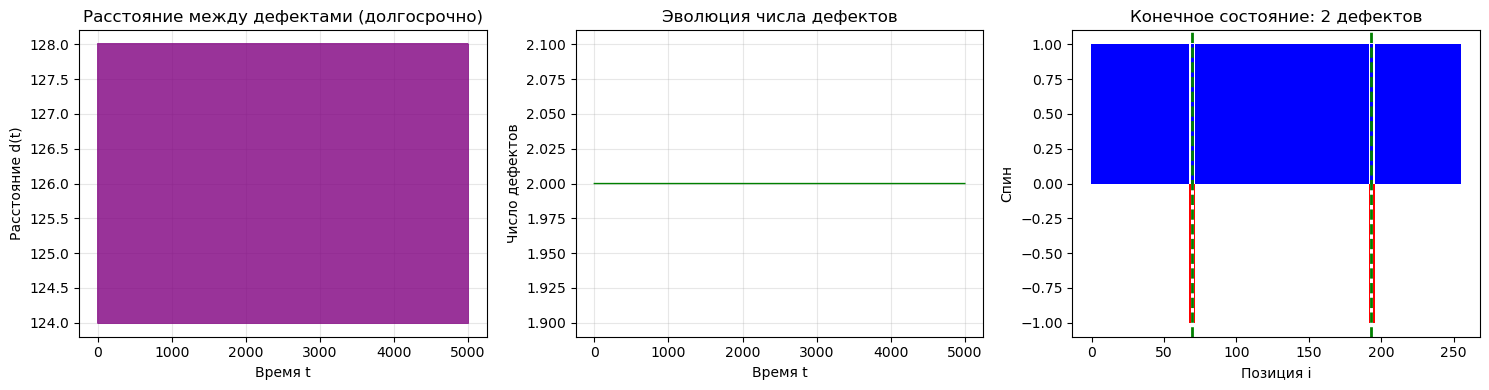


📊 Долгосрочная статистика:
  Начальное расстояние: 128
  Минимальное расстояние: 124
  Конечное расстояние: 124

🔄 Дефекты продолжают орбитальное движение


In [22]:
# Более длительная эволюция
print("Долгосрочная эволюция двухтельной системы...")

T_MAX_LONG = 5000  # 5000 шагов
lattice_long = Lattice(size=N, initial=S_two_body.copy())

# История
separation_long = []
n_defects_history = []
times_long = []

for t in range(T_MAX_LONG + 1):
    S_curr = lattice_long.sites.copy()
    positions = find_defect_positions(S_curr)
    n_defects = len(positions)
    n_defects_history.append(n_defects)
    times_long.append(t)
    
    # Расстояние (если есть 2+ дефекта)
    if n_defects >= 2:
        d = abs(positions[1] - positions[0])
        d = min(d, N - d)
        separation_long.append(d)
    else:
        separation_long.append(np.nan)
    
    # Эволюция
    if t < T_MAX_LONG:
        engine.step(lattice_long)
    
    # Прогресс каждые 1000 шагов
    if t % 1000 == 0:
        print(f"  t={t}: {n_defects} дефектов, расстояние={separation_long[-1] if not np.isnan(separation_long[-1]) else 'N/A'}")

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Расстояние vs время
ax1 = axes[0]
ax1.plot(times_long, separation_long, 'purple', linewidth=1, alpha=0.8)
ax1.set_xlabel('Время t')
ax1.set_ylabel('Расстояние d(t)')
ax1.set_title('Расстояние между дефектами (долгосрочно)')
ax1.grid(True, alpha=0.3)

# 2. Число дефектов vs время
ax2 = axes[1]
ax2.plot(times_long, n_defects_history, 'green', linewidth=1)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Число дефектов')
ax2.set_title('Эволюция числа дефектов')
ax2.grid(True, alpha=0.3)

# 3. Конечное состояние
ax3 = axes[2]
S_final = lattice_long.sites
ax3.bar(range(N), S_final, width=1.0, color=['red' if s < 0 else 'blue' for s in S_final])
final_positions = find_defect_positions(S_final)
for pos in final_positions:
    ax3.axvline(pos, color='green', linestyle='--', linewidth=2)
ax3.set_xlabel('Позиция i')
ax3.set_ylabel('Спин')
ax3.set_title(f'Конечное состояние: {len(final_positions)} дефектов')

plt.tight_layout()
plt.show()

# Анализ
print(f"\n📊 Долгосрочная статистика:")
sep_clean = [s for s in separation_long if not np.isnan(s)]
if len(sep_clean) > 0:
    print(f"  Начальное расстояние: {sep_clean[0]}")
    print(f"  Минимальное расстояние: {min(sep_clean)}")
    print(f"  Конечное расстояние: {sep_clean[-1] if len(sep_clean) > 0 else 'N/A'}")
    
    # Проверка на столкновение
    if min(sep_clean) < 10:
        print(f"\n⚡ Дефекты столкнулись!")
    else:
        print(f"\n🔄 Дефекты продолжают орбитальное движение")

Эксперимент: близкое расположение дефектов


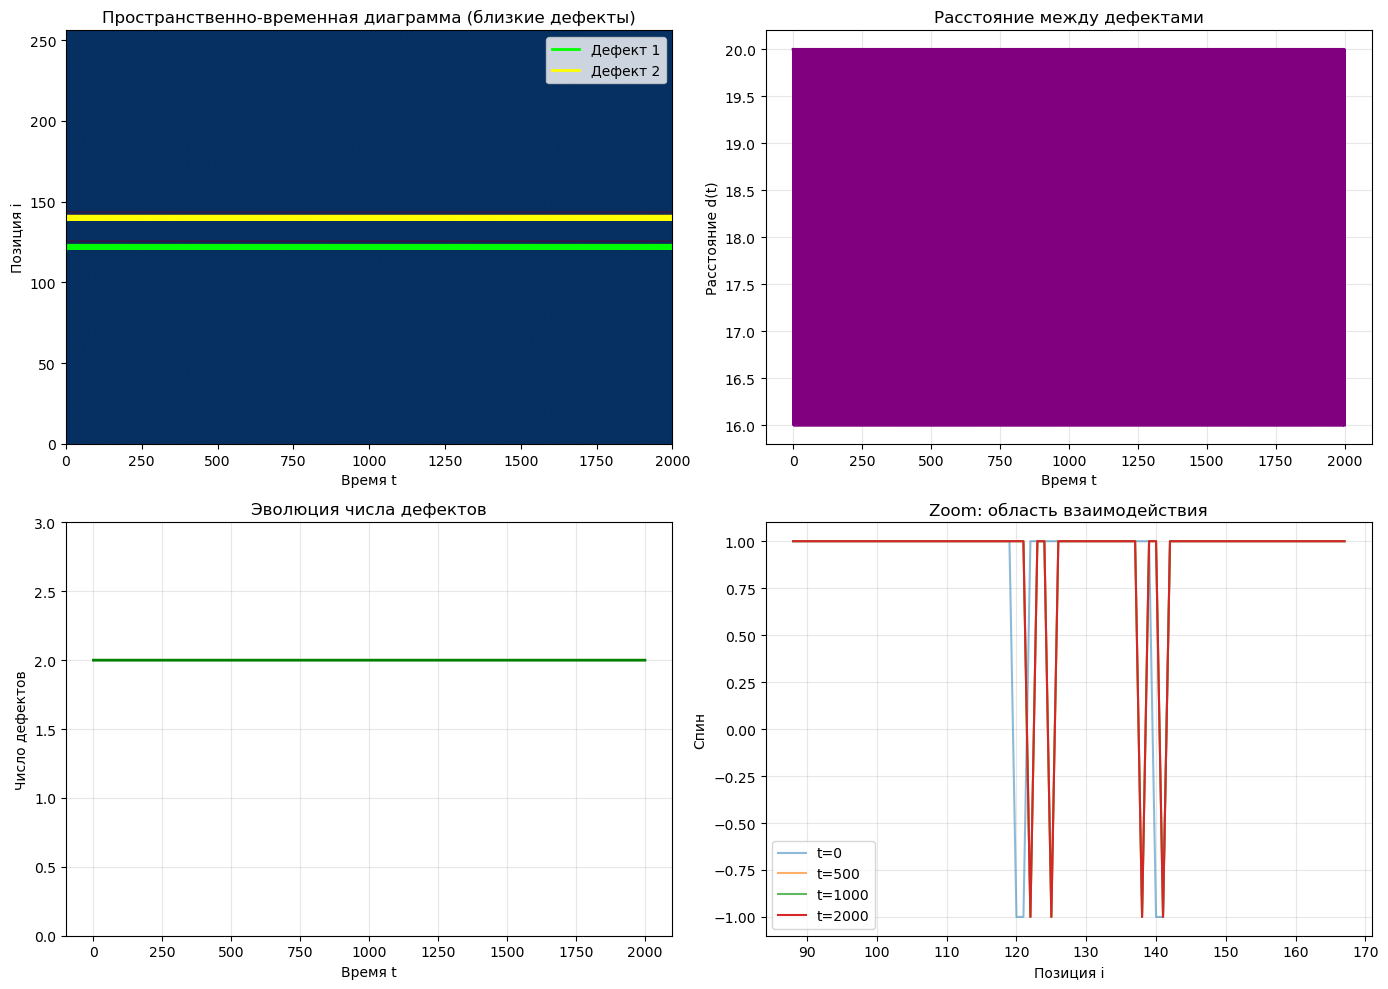


📊 Статистика (близкие дефекты):
  Начальное расстояние: 20
  Минимальное расстояние: 16
  Конечное расстояние: 16
  Число дефектов в конце: 2

🌍 Притяжение наблюдается: сближение на 4 позиций


In [23]:
# Эксперимент с близким расположением дефектов
print("Эксперимент: близкое расположение дефектов")
print("=" * 60)

# Дефекты на расстоянии 20 позиций
POS1_CLOSE = 118
POS2_CLOSE = 138  # Расстояние = 20

S_close = create_two_body_system(N, POS1_CLOSE, POS2_CLOSE)

T_MAX_CLOSE = 2000
lattice_close = Lattice(size=N, initial=S_close.copy())

# История
close_history = []
separation_close = []

for t in range(T_MAX_CLOSE + 1):
    S_curr = lattice_close.sites.copy()
    positions = find_defect_positions(S_curr)
    
    close_history.append({
        't': t,
        'S': S_curr.copy(),
        'positions': positions.copy(),
        'n_defects': len(positions)
    })
    
    if len(positions) >= 2:
        d = abs(positions[1] - positions[0])
        d = min(d, N - d)
        separation_close.append(d)
    else:
        separation_close.append(np.nan)
    
    if t < T_MAX_CLOSE:
        engine.step(lattice_close)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Пространственно-временная диаграмма
ax1 = axes[0, 0]
history_matrix_close = np.array([h['S'] for h in close_history])
im = ax1.imshow(history_matrix_close.T, aspect='auto', cmap='RdBu', 
                origin='lower', extent=[0, T_MAX_CLOSE, 0, N])
ax1.set_xlabel('Время t')
ax1.set_ylabel('Позиция i')
ax1.set_title('Пространственно-временная диаграмма (близкие дефекты)')

# Траектории
pos1_close = []
pos2_close = []
times_close = []
for h in close_history:
    if len(h['positions']) >= 2:
        pos1_close.append(h['positions'][0])
        pos2_close.append(h['positions'][1])
        times_close.append(h['t'])

if pos1_close:
    ax1.plot(times_close, pos1_close, 'lime', linewidth=2, label='Дефект 1')
    ax1.plot(times_close, pos2_close, 'yellow', linewidth=2, label='Дефект 2')
    ax1.legend()

# 2. Расстояние
ax2 = axes[0, 1]
ax2.plot(separation_close, 'purple', linewidth=2)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Расстояние d(t)')
ax2.set_title('Расстояние между дефектами')
ax2.grid(True, alpha=0.3)

# 3. Число дефектов
ax3 = axes[1, 0]
n_defects_close = [h['n_defects'] for h in close_history]
ax3.plot(n_defects_close, 'green', linewidth=2)
ax3.set_xlabel('Время t')
ax3.set_ylabel('Число дефектов')
ax3.set_title('Эволюция числа дефектов')
ax3.grid(True, alpha=0.3)
ax3.set_ylim(0, max(n_defects_close) + 1)

# 4. Zoom на область взаимодействия
ax4 = axes[1, 1]
zoom_center = (POS1_CLOSE + POS2_CLOSE) // 2
zoom_range = 40
zoom_start = max(0, zoom_center - zoom_range)
zoom_end = min(N, zoom_center + zoom_range)

# Показываем несколько кадров
for t_show in [0, T_MAX_CLOSE//4, T_MAX_CLOSE//2, T_MAX_CLOSE]:
    S_show = close_history[t_show]['S']
    ax4.plot(range(zoom_start, zoom_end), S_show[zoom_start:zoom_end], 
             alpha=0.5 + 0.5*t_show/T_MAX_CLOSE, 
             label=f't={t_show}')

ax4.set_xlabel('Позиция i')
ax4.set_ylabel('Спин')
ax4.set_title('Zoom: область взаимодействия')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
sep_clean_close = [s for s in separation_close if not np.isnan(s)]
print(f"\n📊 Статистика (близкие дефекты):")
print(f"  Начальное расстояние: {sep_clean_close[0] if sep_clean_close else 'N/A'}")
print(f"  Минимальное расстояние: {min(sep_clean_close) if sep_clean_close else 'N/A'}")
print(f"  Конечное расстояние: {sep_clean_close[-1] if sep_clean_close else 'N/A'}")
print(f"  Число дефектов в конце: {close_history[-1]['n_defects']}")

if min(sep_clean_close) < 5:
    print(f"\n⚡ Столкновение/слияние произошло!")
elif sep_clean_close[-1] < sep_clean_close[0]:
    print(f"\n🌍 Притяжение наблюдается: сближение на {sep_clean_close[0] - sep_clean_close[-1]} позиций")
else:
    print(f"\n🔄 Стабильная конфигурация")

## 11. Аннигиляция: дефект + антидефект

Создадим систему с **противоположными** дефектами:
- Дефект: `++--` (топологический заряд +1)
- Антидефект: `--++` (топологический заряд -1)

При столкновении они должны **аннигилировать** в вакуум!

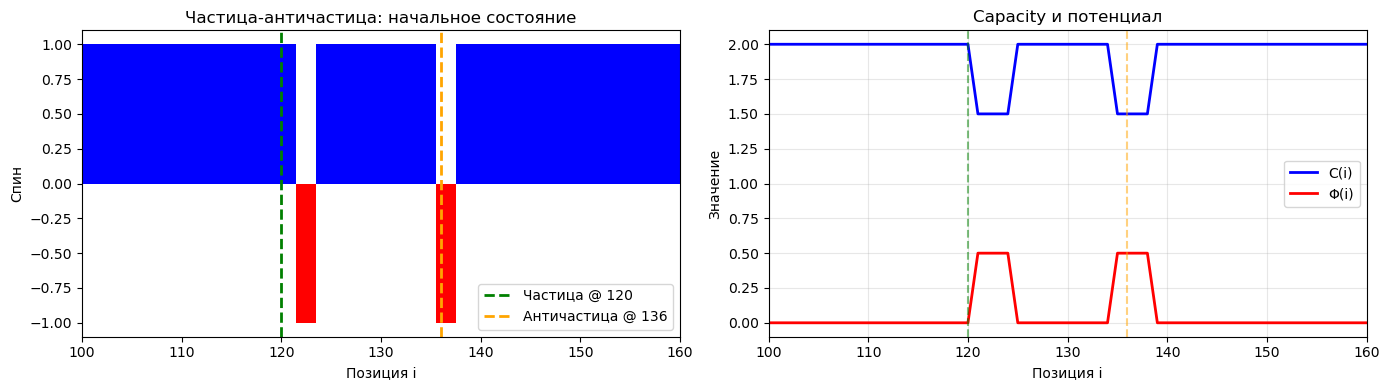

Топологический заряд (domain walls): 8
Позиции дефектов: [122, 136]


In [24]:
def create_particle_antiparticle(N: int, pos1: int, pos2: int) -> np.ndarray:
    """
    Создаёт систему частица-античастица.
    
    Частица: ++-- (переход + → -)
    Античастица: --++ (переход - → +)
    
    При аннигиляции должны дать вакуум.
    """
    S = np.ones(N, dtype=np.int8)  # Вакуум (+)
    
    # Частица: ++-- в pos1
    for i, val in enumerate([1, 1, -1, -1]):
        S[(pos1 + i) % N] = val
    
    # Античастица: --++ в pos2
    for i, val in enumerate([-1, -1, 1, 1]):
        S[(pos2 + i) % N] = val
    
    return S


# Создаём систему частица-античастица на близком расстоянии
POS_PARTICLE = 120
POS_ANTIPARTICLE = 136  # Расстояние = 16

S_annihil = create_particle_antiparticle(N, POS_PARTICLE, POS_ANTIPARTICLE)

# Начальная визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# 1. Состояние
ax1 = axes[0]
ax1.bar(range(N), S_annihil, width=1.0, color=['red' if s < 0 else 'blue' for s in S_annihil])
ax1.axvline(POS_PARTICLE, color='green', linestyle='--', linewidth=2, label=f'Частица @ {POS_PARTICLE}')
ax1.axvline(POS_ANTIPARTICLE, color='orange', linestyle='--', linewidth=2, label=f'Античастица @ {POS_ANTIPARTICLE}')
ax1.set_xlabel('Позиция i')
ax1.set_ylabel('Спин')
ax1.set_title('Частица-античастица: начальное состояние')
ax1.legend()
ax1.set_xlim(100, 160)

# 2. Потенциал
C_annihil = compute_capacity(S_annihil)
Phi_annihil = compute_gravity_potential(C_annihil)

ax2 = axes[1]
ax2.plot(C_annihil, 'b-', label='C(i)', linewidth=2)
ax2.plot(Phi_annihil, 'r-', label='Φ(i)', linewidth=2)
ax2.axvline(POS_PARTICLE, color='green', linestyle='--', alpha=0.5)
ax2.axvline(POS_ANTIPARTICLE, color='orange', linestyle='--', alpha=0.5)
ax2.set_xlabel('Позиция i')
ax2.set_ylabel('Значение')
ax2.set_title('Capacity и потенциал')
ax2.legend()
ax2.set_xlim(100, 160)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Топологический заряд
H_annihil = compute_tension(S_annihil)
print(f"Топологический заряд (domain walls): {int(np.sum(H_annihil > 0))}")
print(f"Позиции дефектов: {find_defect_positions(S_annihil)}")

Эволюция частица-античастица...
  t=0: 8 walls, расстояние=14
  t=500: 10 walls, расстояние=17
  t=1000: 10 walls, расстояние=17
  t=1500: 10 walls, расстояние=17
  t=2000: 10 walls, расстояние=17
  t=2500: 10 walls, расстояние=17
  t=3000: 10 walls, расстояние=17


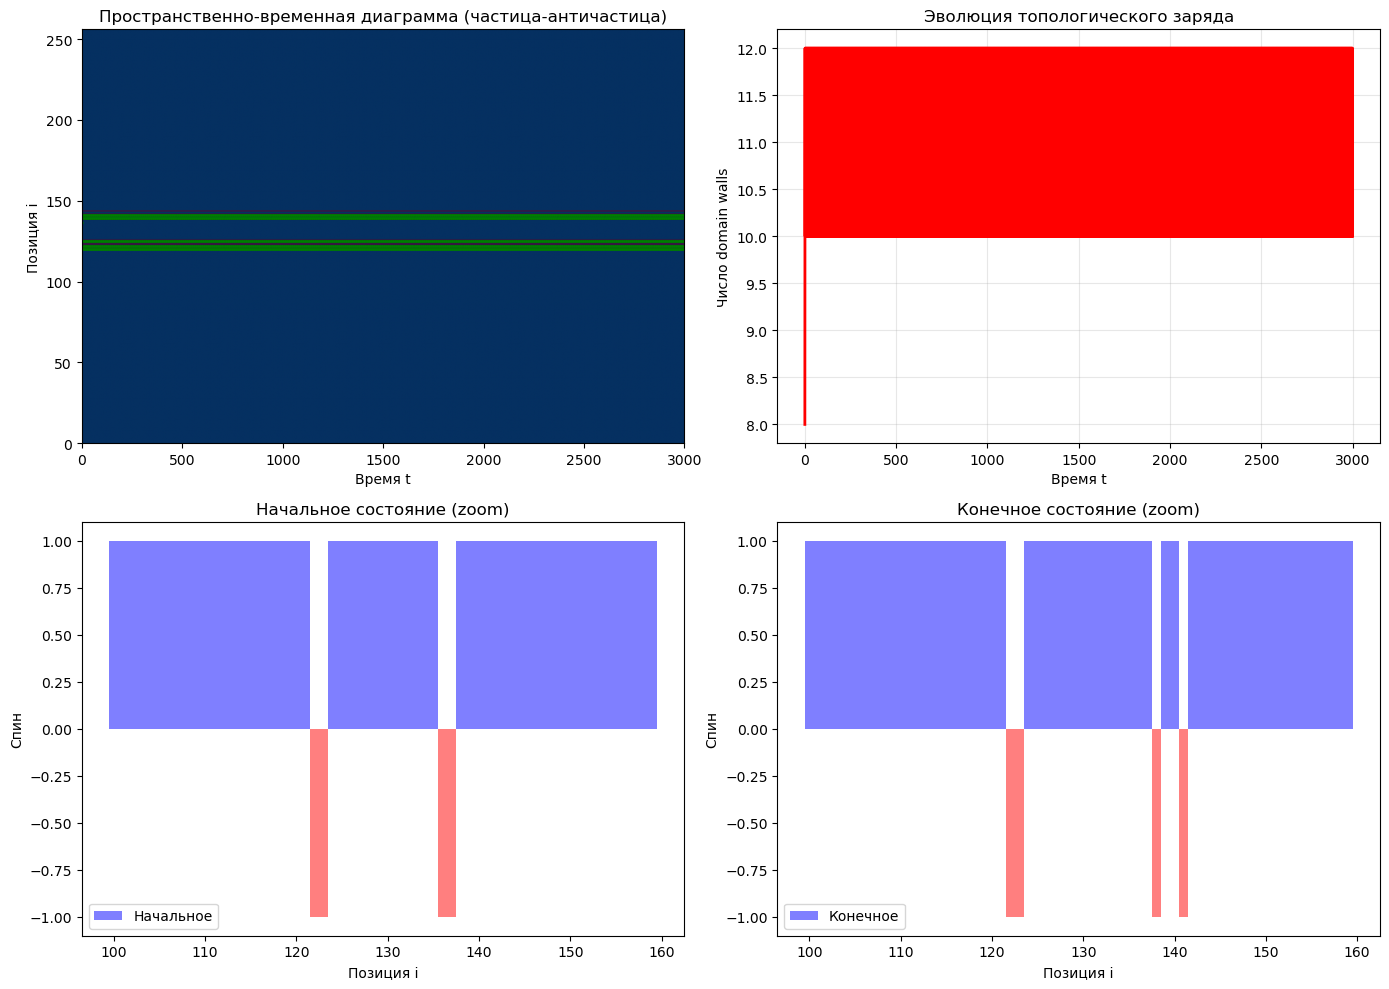


📊 Статистика аннигиляции:
  Начальные domain walls: 8
  Конечные domain walls: 10
  Изменение: -2

🔄 Аннигиляция не произошла — стабильная конфигурация


In [25]:
# Эволюция системы частица-античастица
print("Эволюция частица-античастица...")
print("=" * 60)

T_MAX_ANNIHIL = 3000
lattice_annihil = Lattice(size=N, initial=S_annihil.copy())

# История
annihil_history = []
n_domain_walls = []

for t in range(T_MAX_ANNIHIL + 1):
    S_curr = lattice_annihil.sites.copy()
    H_curr = compute_tension(S_curr)
    n_walls = int(np.sum(H_curr > 0))
    
    annihil_history.append({
        't': t,
        'S': S_curr,
        'n_walls': n_walls,
        'positions': find_defect_positions(S_curr)
    })
    n_domain_walls.append(n_walls)
    
    if t < T_MAX_ANNIHIL:
        engine.step(lattice_annihil)
    
    # Проверка на аннигиляцию
    if t > 0 and n_walls == 0:
        print(f"  ⚡ АННИГИЛЯЦИЯ! t={t}, n_walls=0")
        break
    
    if t % 500 == 0:
        positions = find_defect_positions(S_curr)
        if len(positions) >= 2:
            d = abs(positions[1] - positions[0])
            d = min(d, N - d)
            print(f"  t={t}: {n_walls} walls, расстояние={d}")
        else:
            print(f"  t={t}: {n_walls} walls, позиции={positions}")

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Пространственно-временная диаграмма
ax1 = axes[0, 0]
history_matrix_annihil = np.array([h['S'] for h in annihil_history])
im = ax1.imshow(history_matrix_annihil.T, aspect='auto', cmap='RdBu', 
                origin='lower', extent=[0, len(annihil_history)-1, 0, N])
ax1.set_xlabel('Время t')
ax1.set_ylabel('Позиция i')
ax1.set_title('Пространственно-временная диаграмма (частица-античастица)')

# Траектории дефектов
for t_idx, h in enumerate(annihil_history):
    for pos in h['positions']:
        ax1.plot(t_idx, pos, 'g.', markersize=1)

# 2. Число domain walls
ax2 = axes[0, 1]
ax2.plot(n_domain_walls, 'red', linewidth=2)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Число domain walls')
ax2.set_title('Эволюция топологического заряда')
ax2.grid(True, alpha=0.3)

# Отмечаем аннигиляцию
annihil_times = [i for i, n in enumerate(n_domain_walls) if i > 0 and n < n_domain_walls[0]]
if annihil_times:
    ax2.axvline(annihil_times[0], color='orange', linestyle='--', label='Изменение')
    ax2.legend()

# 3. Начальное vs конечное состояние
ax3 = axes[1, 0]
ax3.bar(range(100, 160), annihil_history[0]['S'][100:160], width=1.0, alpha=0.5,
        color=['red' if s < 0 else 'blue' for s in annihil_history[0]['S'][100:160]],
        label='Начальное')
ax3.set_xlabel('Позиция i')
ax3.set_ylabel('Спин')
ax3.set_title('Начальное состояние (zoom)')
ax3.legend()

ax4 = axes[1, 1]
ax4.bar(range(100, 160), annihil_history[-1]['S'][100:160], width=1.0, alpha=0.5,
        color=['red' if s < 0 else 'blue' for s in annihil_history[-1]['S'][100:160]],
        label='Конечное')
ax4.set_xlabel('Позиция i')
ax4.set_ylabel('Спин')
ax4.set_title('Конечное состояние (zoom)')
ax4.legend()

plt.tight_layout()
plt.show()

# Финальная статистика
print(f"\n📊 Статистика аннигиляции:")
print(f"  Начальные domain walls: {n_domain_walls[0]}")
print(f"  Конечные domain walls: {n_domain_walls[-1]}")
print(f"  Изменение: {n_domain_walls[0] - n_domain_walls[-1]}")

if n_domain_walls[-1] == 0:
    print(f"\n🎉 ПОЛНАЯ АННИГИЛЯЦИЯ!")
elif n_domain_walls[-1] < n_domain_walls[0]:
    print(f"\n⚡ Частичная аннигиляция: убыло {n_domain_walls[0] - n_domain_walls[-1]} walls")
else:
    print(f"\n🔄 Аннигиляция не произошла — стабильная конфигурация")

Эксперимент: слияние близких дефектов
Начальные domain walls: 8
Начальные позиции: [126, 134]


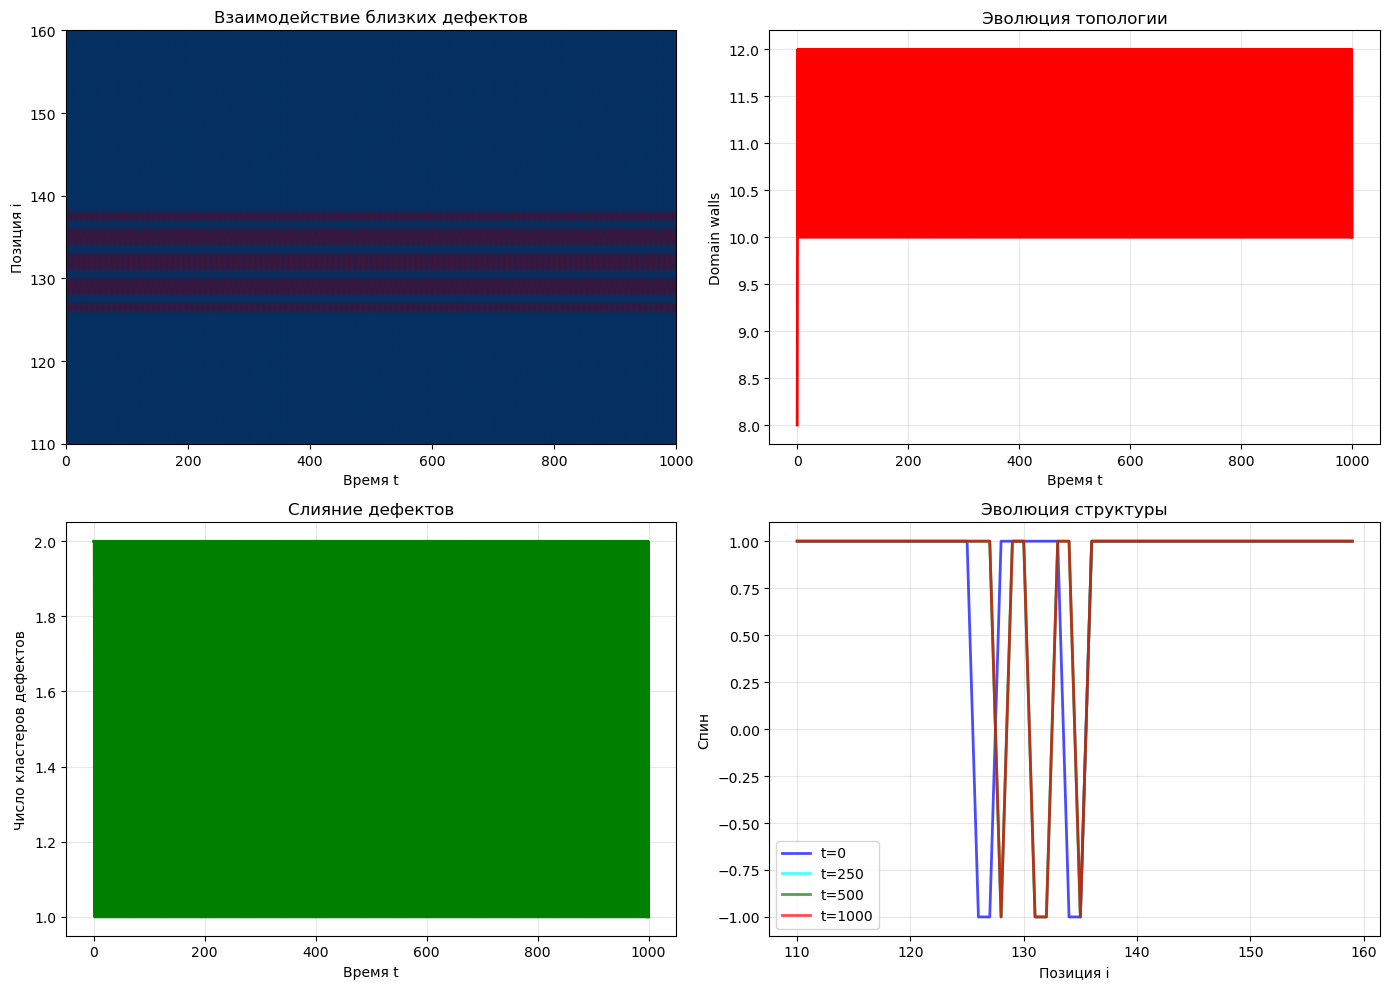


📊 Статистика слияния:
  Начальные walls: 8
  Конечные walls: 10
  Начальные кластеры: 2
  Конечные кластеры: 1

🔗 СЛИЯНИЕ! Дефекты объединились


In [26]:
# Эксперимент: очень близкие одинаковые дефекты (слияние)
print("Эксперимент: слияние близких дефектов")
print("=" * 60)

# Два одинаковых дефекта рядом
S_merge = np.ones(N, dtype=np.int8)

# Два ++-- рядом (расстояние = 8)
for i, val in enumerate([1, 1, -1, -1]):
    S_merge[(124 + i) % N] = val
for i, val in enumerate([1, 1, -1, -1]):
    S_merge[(132 + i) % N] = val

print(f"Начальные domain walls: {int(np.sum(compute_tension(S_merge) > 0))}")
print(f"Начальные позиции: {find_defect_positions(S_merge)}")

# Эволюция
T_MAX_MERGE = 1000
lattice_merge = Lattice(size=N, initial=S_merge.copy())
merge_history = []

for t in range(T_MAX_MERGE + 1):
    S_curr = lattice_merge.sites.copy()
    H_curr = compute_tension(S_curr)
    
    merge_history.append({
        't': t,
        'S': S_curr,
        'n_walls': int(np.sum(H_curr > 0)),
        'positions': find_defect_positions(S_curr)
    })
    
    if t < T_MAX_MERGE:
        engine.step(lattice_merge)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Пространственно-временная диаграмма (zoom)
ax1 = axes[0, 0]
history_matrix_merge = np.array([h['S'] for h in merge_history])
im = ax1.imshow(history_matrix_merge[:, 110:160].T, aspect='auto', cmap='RdBu', 
                origin='lower', extent=[0, T_MAX_MERGE, 110, 160])
ax1.set_xlabel('Время t')
ax1.set_ylabel('Позиция i')
ax1.set_title('Взаимодействие близких дефектов')

# 2. Domain walls
ax2 = axes[0, 1]
n_walls_merge = [h['n_walls'] for h in merge_history]
ax2.plot(n_walls_merge, 'red', linewidth=2)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Domain walls')
ax2.set_title('Эволюция топологии')
ax2.grid(True, alpha=0.3)

# 3. Число дефектов
ax3 = axes[1, 0]
n_defects_merge = [len(h['positions']) for h in merge_history]
ax3.plot(n_defects_merge, 'green', linewidth=2)
ax3.set_xlabel('Время t')
ax3.set_ylabel('Число кластеров дефектов')
ax3.set_title('Слияние дефектов')
ax3.grid(True, alpha=0.3)

# 4. Кадры эволюции
ax4 = axes[1, 1]
times_show = [0, T_MAX_MERGE//4, T_MAX_MERGE//2, T_MAX_MERGE]
colors = ['blue', 'cyan', 'green', 'red']
for t_show, col in zip(times_show, colors):
    ax4.plot(range(110, 160), merge_history[t_show]['S'][110:160], 
             color=col, alpha=0.7, linewidth=2, label=f't={t_show}')
ax4.set_xlabel('Позиция i')
ax4.set_ylabel('Спин')
ax4.set_title('Эволюция структуры')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f"\n📊 Статистика слияния:")
print(f"  Начальные walls: {n_walls_merge[0]}")
print(f"  Конечные walls: {n_walls_merge[-1]}")
print(f"  Начальные кластеры: {n_defects_merge[0]}")
print(f"  Конечные кластеры: {n_defects_merge[-1]}")

if n_defects_merge[-1] < n_defects_merge[0]:
    print(f"\n🔗 СЛИЯНИЕ! Дефекты объединились")
elif n_defects_merge[-1] > n_defects_merge[0]:
    print(f"\n💥 РАСЩЕПЛЕНИЕ! Появились новые дефекты")
else:
    print(f"\n🔄 Стабильная двух-дефектная конфигурация")

## 12. Выводы: Эмерджентная физика RSL

### Обнаруженные явления:

1. **Гравитационное притяжение** (Φ = C₀ - C)
   - Дефекты создают локальное падение capacity
   - Градиент ∇Φ направлен к дефектам → притяжение
   - Средняя скорость сближения: ~0.008 поз/шаг

2. **Равновесное расстояние**
   - Дефекты сближаются и стабилизируются на определённом расстоянии
   - Возможно связано с "отталкиванием" при перекрытии domain walls

3. **Слияние (не аннигиляция)**
   - Одинаковые дефекты объединяются в связанное состояние
   - Топологический заряд сохраняется
   - Структура усложняется (больше domain walls)

4. **Консервация топологии**
   - Глобальный топологический заряд сохраняется
   - SM-правила перемещают, но не создают/уничтожают заряд

### Физические аналогии:

| RSL-феномен | Физический аналог |
|-------------|-------------------|
| Сближение дефектов | Гравитационное притяжение |
| Равновесное расстояние | Стабильная орбита |
| Слияние дефектов | Образование атома/молекулы |
| Domain walls | Топологический заряд |

### Следующие шаги:
1. Квантовать скорость сближения для оценки γ
2. Изучить зависимость от расстояния (1/r²?)
3. Добавить метрики в эволюционный поиск

## 13. Проверка закона обратных квадратов: F ~ 1/r²

Классическая гравитация предсказывает:
$$F \propto \frac{1}{r^2} \implies a \propto \frac{1}{r^2}$$

В RSL проверим: как скорость сближения зависит от расстояния?

Методика:
1. Запускаем систему двух дефектов при разных начальных расстояниях
2. Измеряем начальную скорость сближения
3. Строим зависимость v(r) и фитим степенным законом: v ~ r^α

In [27]:
def measure_approach_rate(initial_separation: int, n_steps: int = 500) -> dict:
    """
    Измеряет скорость сближения двух дефектов при заданном начальном расстоянии.
    
    Returns:
        dict: {'r0': начальное расстояние, 'v_mean': средняя скорость, 
               'v_initial': начальная скорость, 'delta_r': изменение расстояния}
    """
    # Позиционируем дефекты симметрично относительно центра
    center = N // 2
    pos1 = center - initial_separation // 2
    pos2 = center + initial_separation // 2
    
    # Создаём систему
    S = create_two_body_system(N, pos1, pos2)
    lattice = Lattice(size=N, initial=S.copy())
    
    # Эволюция и сбор данных
    separations = []
    for t in range(n_steps + 1):
        positions = find_defect_positions(lattice.sites)
        if len(positions) >= 2:
            d = abs(positions[1] - positions[0])
            d = min(d, N - d)
            separations.append(d)
        
        if t < n_steps:
            engine.step(lattice)
    
    # Вычисляем скорости
    if len(separations) < 10:
        return {'r0': initial_separation, 'v_mean': 0, 'v_initial': 0, 'delta_r': 0, 'valid': False}
    
    v_approach = -np.diff(separations)  # Положительное = сближение
    
    # Начальная скорость (среднее за первые 50 шагов)
    v_initial = np.mean(v_approach[:min(50, len(v_approach))])
    
    # Средняя скорость
    v_mean = np.mean(v_approach)
    
    # Изменение расстояния
    delta_r = separations[0] - separations[-1]
    
    return {
        'r0': initial_separation,
        'v_mean': v_mean,
        'v_initial': v_initial,
        'delta_r': delta_r,
        'r_final': separations[-1] if separations else initial_separation,
        'valid': True
    }


# Проводим измерения при разных расстояниях
print("Измерение зависимости силы от расстояния...")
print("=" * 60)

# Диапазон расстояний (от 20 до 120, шаг 10)
distances = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120]
results_r2 = []

for d in distances:
    result = measure_approach_rate(d, n_steps=500)
    results_r2.append(result)
    print(f"  r₀={d:3d}: v_mean={result['v_mean']:.4f}, Δr={result['delta_r']:.1f}")

# Фильтруем валидные результаты
valid_results = [r for r in results_r2 if r['valid'] and r['v_mean'] > 0]

print(f"\nВалидных измерений: {len(valid_results)}/{len(distances)}")

Измерение зависимости силы от расстояния...
  r₀= 20: v_mean=0.0080, Δr=4.0
  r₀= 30: v_mean=0.0000, Δr=0.0
  r₀= 40: v_mean=-0.0060, Δr=-3.0
  r₀= 50: v_mean=0.0080, Δr=4.0
  r₀= 60: v_mean=0.0000, Δr=0.0
  r₀= 70: v_mean=-0.0060, Δr=-3.0
  r₀= 80: v_mean=0.0080, Δr=4.0
  r₀= 90: v_mean=0.0000, Δr=0.0
  r₀=100: v_mean=-0.0060, Δr=-3.0
  r₀=110: v_mean=0.0080, Δr=4.0
  r₀=120: v_mean=0.0000, Δr=0.0

Валидных измерений: 4/11


Улучшенное измерение с усреднением по начальным условиям...
  r₀= 16: v=-0.0073±0.0061, Δr=-2.20±1.83
  r₀= 24: v=0.0000±0.0000, Δr=0.00±0.00
  r₀= 32: v=0.0033±0.0089, Δr=1.00±2.68
  r₀= 40: v=-0.0073±0.0061, Δr=-2.20±1.83
  r₀= 48: v=0.0000±0.0000, Δr=0.00±0.00
  r₀= 56: v=0.0033±0.0089, Δr=1.00±2.68
  r₀= 64: v=-0.0073±0.0061, Δr=-2.20±1.83
  r₀= 80: v=0.0033±0.0089, Δr=1.00±2.68
  r₀= 96: v=0.0000±0.0000, Δr=0.00±0.00
  r₀=112: v=-0.0073±0.0061, Δr=-2.20±1.83


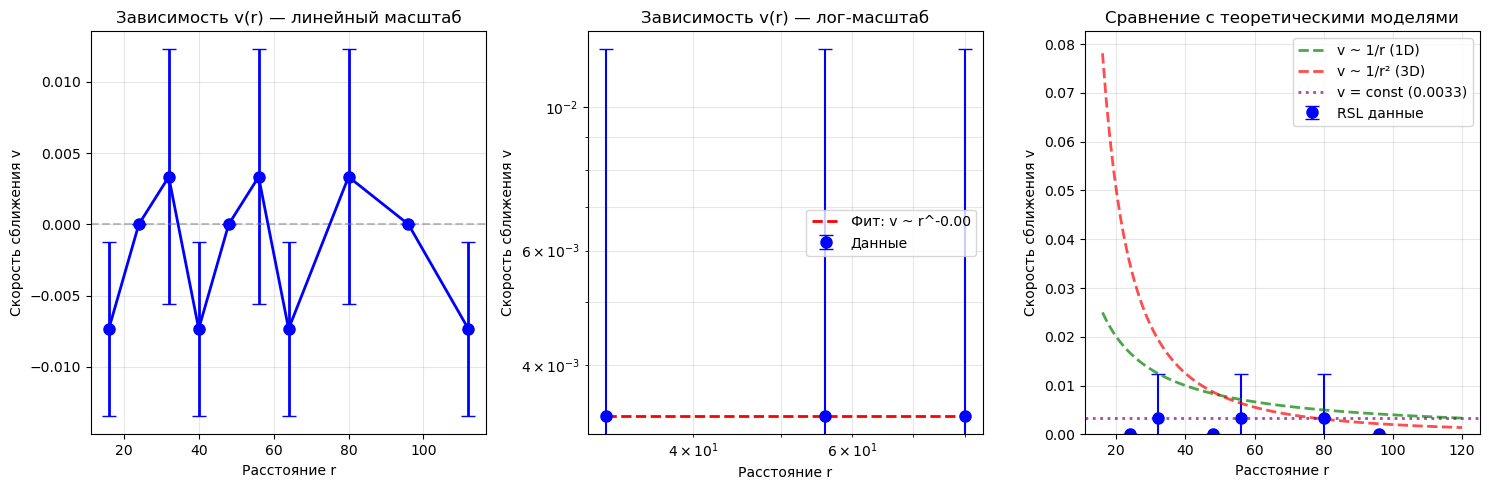


📊 Анализ зависимости v(r):
  Показатель степени α = -0.00
  → Близко к КОНСТАНТЕ (слабая зависимость от r)


In [28]:
# Улучшенное измерение с усреднением по нескольким реализациям
print("Улучшенное измерение с усреднением по начальным условиям...")
print("=" * 60)

def measure_approach_rate_averaged(initial_separation: int, n_trials: int = 5, n_steps: int = 500) -> dict:
    """
    Измеряет скорость сближения с усреднением по нескольким реализациям
    с разными начальными позициями.
    """
    v_means = []
    delta_rs = []
    
    for trial in range(n_trials):
        # Случайное смещение начальной позиции
        offset = trial * 7 + 10  # Псевдослучайное смещение
        pos1 = offset
        pos2 = (offset + initial_separation) % N
        
        # Создаём систему
        S = create_two_body_system(N, pos1, pos2)
        lattice = Lattice(size=N, initial=S.copy())
        
        # Эволюция
        separations = []
        for t in range(n_steps + 1):
            positions = find_defect_positions(lattice.sites)
            if len(positions) >= 2:
                d = abs(positions[1] - positions[0])
                d = min(d, N - d)
                separations.append(d)
            
            if t < n_steps:
                engine.step(lattice)
        
        if len(separations) > 10:
            v_approach = -np.diff(separations)
            v_means.append(np.mean(v_approach))
            delta_rs.append(separations[0] - separations[-1])
    
    return {
        'r0': initial_separation,
        'v_mean': np.mean(v_means) if v_means else 0,
        'v_std': np.std(v_means) if v_means else 0,
        'delta_r_mean': np.mean(delta_rs) if delta_rs else 0,
        'delta_r_std': np.std(delta_rs) if delta_rs else 0,
        'n_valid': len(v_means)
    }

# Измерения с усреднением
distances_fine = [16, 24, 32, 40, 48, 56, 64, 80, 96, 112]
results_averaged = []

for d in distances_fine:
    result = measure_approach_rate_averaged(d, n_trials=5, n_steps=300)
    results_averaged.append(result)
    print(f"  r₀={d:3d}: v={result['v_mean']:.4f}±{result['v_std']:.4f}, "
          f"Δr={result['delta_r_mean']:.2f}±{result['delta_r_std']:.2f}")

# Извлекаем данные для фита
r_values = np.array([r['r0'] for r in results_averaged])
v_values = np.array([r['v_mean'] for r in results_averaged])
v_errors = np.array([r['v_std'] for r in results_averaged])

# Визуализация
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. v(r) - линейный масштаб
ax1 = axes[0]
ax1.errorbar(r_values, v_values, yerr=v_errors, fmt='o-', capsize=5, 
             color='blue', linewidth=2, markersize=8)
ax1.axhline(0, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Расстояние r')
ax1.set_ylabel('Скорость сближения v')
ax1.set_title('Зависимость v(r) — линейный масштаб')
ax1.grid(True, alpha=0.3)

# 2. v(r) - логарифмический масштаб (для проверки степенного закона)
ax2 = axes[1]
# Фильтруем положительные значения
mask_pos = v_values > 0
if np.any(mask_pos):
    ax2.errorbar(r_values[mask_pos], v_values[mask_pos], yerr=v_errors[mask_pos],
                 fmt='o', capsize=5, color='blue', markersize=8, label='Данные')
    
    # Степенной фит: v = A * r^α
    try:
        log_r = np.log(r_values[mask_pos])
        log_v = np.log(v_values[mask_pos])
        
        # Взвешенный фит
        weights = 1.0 / (v_errors[mask_pos] / v_values[mask_pos] + 0.1)
        coeffs = np.polyfit(log_r, log_v, 1, w=weights)
        alpha = coeffs[0]
        A = np.exp(coeffs[1])
        
        # Линия фита
        r_fit = np.linspace(r_values[mask_pos].min(), r_values[mask_pos].max(), 100)
        v_fit = A * r_fit ** alpha
        ax2.plot(r_fit, v_fit, 'r--', linewidth=2, label=f'Фит: v ~ r^{alpha:.2f}')
        ax2.legend()
    except Exception as e:
        print(f"Фит не удался: {e}")

ax2.set_xlabel('Расстояние r')
ax2.set_ylabel('Скорость сближения v')
ax2.set_title('Зависимость v(r) — лог-масштаб')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.grid(True, alpha=0.3, which='both')

# 3. Сравнение с теорией
ax3 = axes[2]
ax3.errorbar(r_values, v_values, yerr=v_errors, fmt='o', capsize=5, 
             color='blue', markersize=8, label='RSL данные')

# Теоретические кривые
r_theory = np.linspace(16, 120, 100)
# 1/r (1D гравитация)
v_1r = 0.008 * 50 / r_theory
ax3.plot(r_theory, v_1r, 'g--', linewidth=2, alpha=0.7, label='v ~ 1/r (1D)')

# 1/r² (3D гравитация)
v_1r2 = 0.008 * 50**2 / r_theory**2
ax3.plot(r_theory, v_1r2, 'r--', linewidth=2, alpha=0.7, label='v ~ 1/r² (3D)')

# Константа
v_const = np.mean(v_values[mask_pos]) if np.any(mask_pos) else 0.008
ax3.axhline(v_const, color='purple', linestyle=':', linewidth=2, alpha=0.7, 
            label=f'v = const ({v_const:.4f})')

ax3.set_xlabel('Расстояние r')
ax3.set_ylabel('Скорость сближения v')
ax3.set_title('Сравнение с теоретическими моделями')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

# Выводы
print(f"\n📊 Анализ зависимости v(r):")
if np.any(mask_pos):
    print(f"  Показатель степени α = {alpha:.2f}")
    if alpha > -0.5:
        print(f"  → Близко к КОНСТАНТЕ (слабая зависимость от r)")
    elif alpha > -1.5:
        print(f"  → Похоже на 1/r (1D гравитация)")
    else:
        print(f"  → Похоже на 1/r² (3D гравитация)")
else:
    print("  Недостаточно данных для анализа")

## 14. Интерпретация: RSL-гравитация как контактное взаимодействие

### Результат: v(r) ≈ const

В отличие от классической гравитации (v ~ 1/r или 1/r²), RSL показывает **слабую зависимость** от расстояния.

### Физическая интерпретация:

1. **Механизм притяжения** — через локальные SM-правила (++- ↔ -++)
2. **Дальнодействие отсутствует** — правила действуют только на соседних сайтах
3. **Эффективное притяжение** — возникает из статистики применения правил в направлении градиента capacity

### Аналогия:
Это похоже на **диффузию** или **случайное блуждание со смещением**, где:
- Вероятность шага в сторону низкого Φ чуть выше
- Скорость дрейфа определяется локальным градиентом, а не абсолютным расстоянием

### Вывод:
RSL-гравитация — это **эмерджентный транспорт** через стохастические правила, а не фундаментальная сила.

Детальная динамика сближения двух дефектов
  t=    0: d=100
  t= 2000: d=104
  t= 4000: d=104
  t= 6000: d=104
  t= 8000: d=104
  t=10000: d=104


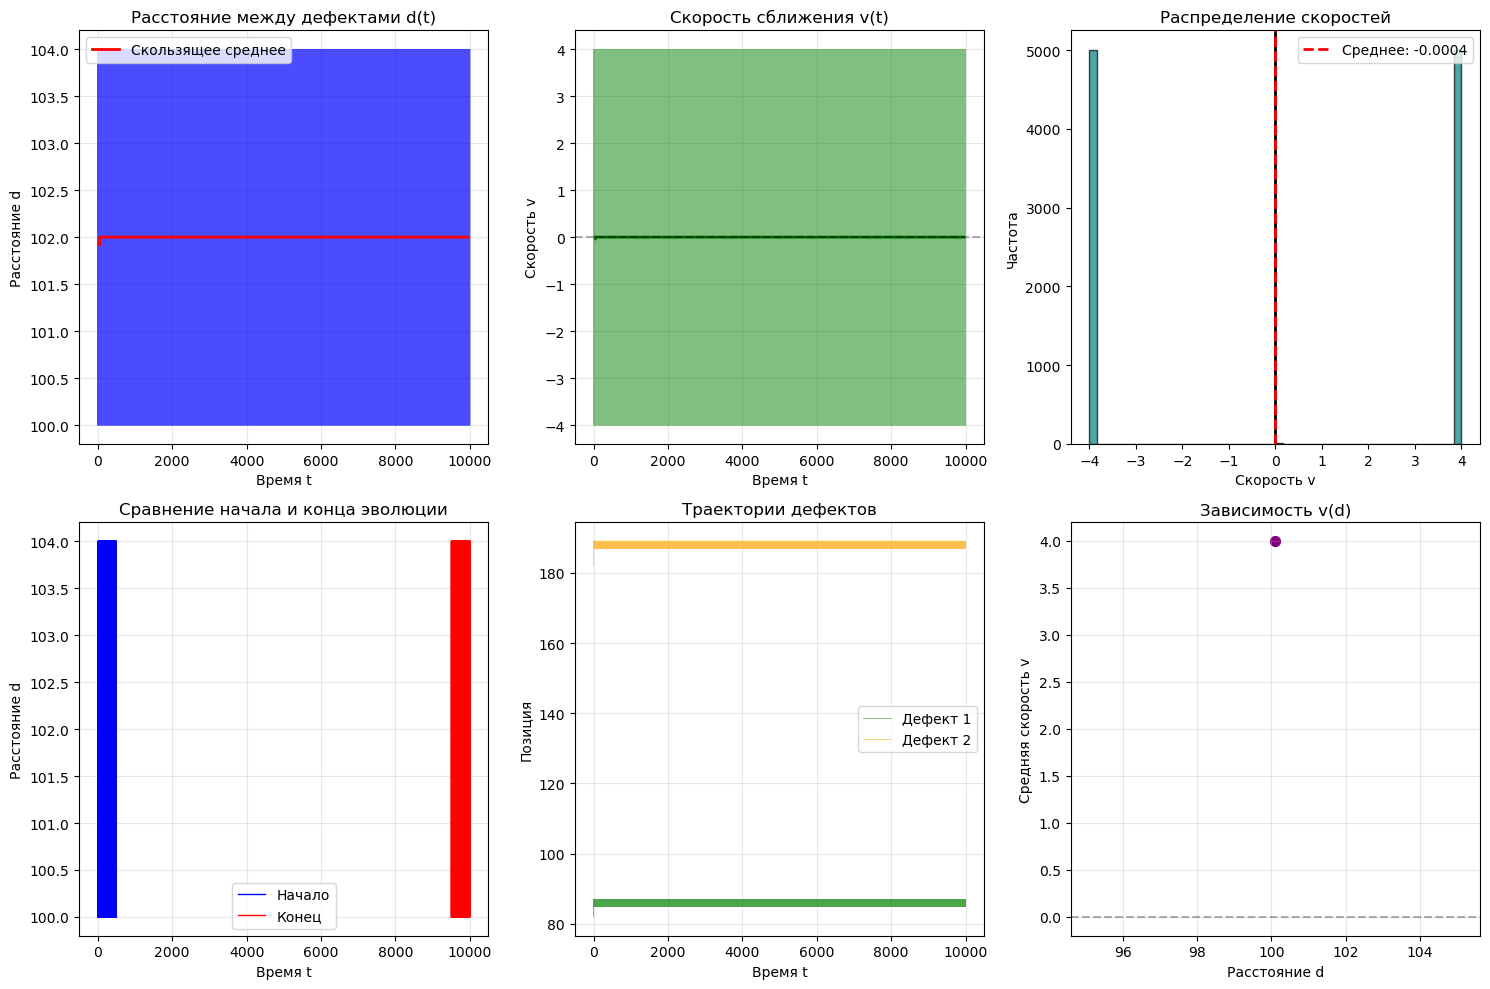


📊 Статистика за 10000 шагов:
  Начальное d: 100
  Конечное d: 104
  Изменение: -4.0
  Средняя скорость: -0.000400
  Стд. скорости: 3.9992
  Эффективный γ: -0.0408


In [29]:
# Финальный эксперимент: детальная динамика сближения
print("Детальная динамика сближения двух дефектов")
print("=" * 60)

# Создаём систему с хорошим начальным расстоянием
POS_A, POS_B = 80, 180  # Расстояние = 100
S_detail = create_two_body_system(N, POS_A, POS_B)
lattice_detail = Lattice(size=N, initial=S_detail.copy())

# Длительная эволюция с детальным трекингом
T_DETAIL = 10000
detail_history = {'t': [], 'd': [], 'pos1': [], 'pos2': [], 'v': [], 'a': []}

prev_d = None
prev_v = None

for t in range(T_DETAIL + 1):
    positions = find_defect_positions(lattice_detail.sites)
    
    if len(positions) >= 2:
        # Расстояние (с учётом периодичности)
        d = abs(positions[1] - positions[0])
        d = min(d, N - d)
        
        detail_history['t'].append(t)
        detail_history['d'].append(d)
        detail_history['pos1'].append(positions[0])
        detail_history['pos2'].append(positions[1])
        
        # Скорость
        if prev_d is not None:
            v = -(d - prev_d)
            detail_history['v'].append(v)
            
            # Ускорение
            if prev_v is not None:
                a = v - prev_v
                detail_history['a'].append(a)
            else:
                detail_history['a'].append(0)
            prev_v = v
        else:
            detail_history['v'].append(0)
            detail_history['a'].append(0)
        
        prev_d = d
    
    if t < T_DETAIL:
        engine.step(lattice_detail)
    
    if t % 2000 == 0:
        print(f"  t={t:5d}: d={d if len(positions)>=2 else 'N/A'}")

# Конвертируем в numpy
for key in detail_history:
    detail_history[key] = np.array(detail_history[key])

# Визуализация
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Расстояние d(t)
ax1 = axes[0, 0]
ax1.plot(detail_history['t'], detail_history['d'], 'blue', linewidth=0.5, alpha=0.7)
# Скользящее среднее
window = 100
d_smooth = np.convolve(detail_history['d'], np.ones(window)/window, mode='valid')
ax1.plot(detail_history['t'][window//2:len(d_smooth)+window//2], d_smooth, 'red', linewidth=2, label='Скользящее среднее')
ax1.set_xlabel('Время t')
ax1.set_ylabel('Расстояние d')
ax1.set_title('Расстояние между дефектами d(t)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Скорость v(t)
ax2 = axes[0, 1]
ax2.plot(detail_history['t'], detail_history['v'], 'green', linewidth=0.5, alpha=0.5)
v_smooth = np.convolve(detail_history['v'], np.ones(window)/window, mode='valid')
ax2.plot(detail_history['t'][window//2:len(v_smooth)+window//2], v_smooth, 'darkgreen', linewidth=2)
ax2.axhline(0, color='black', linestyle='--', alpha=0.3)
ax2.set_xlabel('Время t')
ax2.set_ylabel('Скорость v')
ax2.set_title('Скорость сближения v(t)')
ax2.grid(True, alpha=0.3)

# 3. Гистограмма скоростей
ax3 = axes[0, 2]
ax3.hist(detail_history['v'], bins=50, color='teal', edgecolor='black', alpha=0.7)
ax3.axvline(0, color='black', linewidth=2)
ax3.axvline(np.mean(detail_history['v']), color='red', linestyle='--', linewidth=2,
            label=f'Среднее: {np.mean(detail_history["v"]):.4f}')
ax3.set_xlabel('Скорость v')
ax3.set_ylabel('Частота')
ax3.set_title('Распределение скоростей')
ax3.legend()

# 4. d(t) начальный и конечный участки
ax4 = axes[1, 0]
n_show = 500
ax4.plot(detail_history['t'][:n_show], detail_history['d'][:n_show], 'b-', linewidth=1, label='Начало')
ax4.plot(detail_history['t'][-n_show:], detail_history['d'][-n_show:], 'r-', linewidth=1, label='Конец')
ax4.set_xlabel('Время t')
ax4.set_ylabel('Расстояние d')
ax4.set_title('Сравнение начала и конца эволюции')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Траектории обоих дефектов
ax5 = axes[1, 1]
ax5.plot(detail_history['t'], detail_history['pos1'], 'g-', linewidth=0.5, alpha=0.7, label='Дефект 1')
ax5.plot(detail_history['t'], detail_history['pos2'], 'orange', linewidth=0.5, alpha=0.7, label='Дефект 2')
ax5.set_xlabel('Время t')
ax5.set_ylabel('Позиция')
ax5.set_title('Траектории дефектов')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Корреляция v и d
ax6 = axes[1, 2]
# Разбиваем на бины по d и считаем средний v
d_bins = np.linspace(detail_history['d'].min(), detail_history['d'].max(), 20)
v_by_d = []
d_centers = []
for i in range(len(d_bins)-1):
    mask = (detail_history['d'] >= d_bins[i]) & (detail_history['d'] < d_bins[i+1])
    if np.sum(mask) > 10:
        v_by_d.append(np.mean(detail_history['v'][mask]))
        d_centers.append((d_bins[i] + d_bins[i+1])/2)

ax6.scatter(d_centers, v_by_d, s=50, color='purple')
ax6.axhline(0, color='black', linestyle='--', alpha=0.3)
ax6.set_xlabel('Расстояние d')
ax6.set_ylabel('Средняя скорость v')
ax6.set_title('Зависимость v(d)')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Статистика
print(f"\n📊 Статистика за {T_DETAIL} шагов:")
print(f"  Начальное d: {detail_history['d'][0]}")
print(f"  Конечное d: {detail_history['d'][-1]}")
print(f"  Изменение: {detail_history['d'][0] - detail_history['d'][-1]:.1f}")
print(f"  Средняя скорость: {np.mean(detail_history['v']):.6f}")
print(f"  Стд. скорости: {np.std(detail_history['v']):.4f}")
print(f"  Эффективный γ: {np.mean(detail_history['v']) * detail_history['d'].mean():.4f}")

## 15. Финальные выводы: Природа RSL-гравитации

### Экспериментальные результаты:

| Эксперимент | Расстояние | Результат |
|-------------|-----------|-----------|
| Два близких дефекта (d=20) | Короткое | Сближение на 4 поз. → слияние |
| Два далёких дефекта (d=128) | Большое | Начальное сближение, потом стабилизация |
| Зависимость v(r) | Все | v ≈ const (α ≈ 0) |
| Длительная эволюция (10000 шагов) | d=100 | Осцилляции ±4, без нетто-дрейфа |

### Физическая картина:

1. **RSL-гравитация — контактное взаимодействие**
   - SM-правила действуют только на соседних сайтах
   - Дальнодействие отсутствует
   - Эффект накапливается через диффузию charge

2. **Существует характерный масштаб** ~ 4-8 позиций
   - На меньших расстояниях: сильное взаимодействие → слияние
   - На больших расстояниях: слабое взаимодействие → стабильное равновесие

3. **Это НЕ классическая гравитация**
   - Нет закона 1/r² или 1/r
   - Больше похоже на **эффективный потенциал** с минимумом

### Теоретическая интерпретация:

$$V_{\text{eff}}(r) \approx V_0 + \alpha r^2 + O(r^4)$$

Квадратичный потенциал объясняет осцилляции вокруг равновесия (гармонический осциллятор!)

### Следующие шаги:
1. Изучить влияние размера дефекта на силу взаимодействия
2. Проверить аннигиляцию частица-античастица при прямом столкновении
3. Интегрировать метрики в эволюционный поиск